# Bank of England Sentiment Analysis
## Employer Project
### Team 8 AnalytIQ, June 2nd, 2025
**Team Members**: Lalitha Vemuri, Christina Tsoulfa, Reka Bodo, Yann Hirsig, Louis Pang, Dr. Karin Agius Ferrante

## Content
1. Approach
2. Load the Data
4. Exploratory Sentiment Analysis & Natural Language Processing (NLP)
5. Exploratory Analysis for Correlation with Economic Indicators
8. Insights & Recommendations

## 1. Approach

The **Bank of England (BoE)**, the UK’s central bank and one of the world’s leading financial institutions, plays a pivotal role in maintaining economic and financial stability, and supporting the UK government’s economic policies. One of its key communication channels with the public and markets is through formal speeches delivered by its representatives. These speeches aim to offer guidance, manage expectations, and provide clarity in times of uncertainty.

However, the effectiveness and impact of these speeches on economic indicators and market behaviour are not fully understood. 

This project seeks to explore whether the sentiment and timing of BoE speeches hold analytical or predictive value, when compared with economic performance and key events.

### Main Business Questions
**Has the tone or sentiment of the BoE’s speeches evolved over time? If so, how?**<br>
**How do sentiments align with events like interest rate changes, policy reports, or major economic releases?**

**Sub-questions**

1.	Are there measurable correlations between speech sentiment and UK economic indicators such as inflation, GDP, employment rates and bond yields?
2. Does the change in sentiment change economic indicators or is the speech sentiment reactive to economic indicators?
3. Can speech sentiment trends be used to predict market reactions or economic outcomes?
4. What broader insights can be drawn to support data-informed communication strategies?

## 2. Load the Data

### 2.1. Import libraries

In [11]:
# Install the necessary libraries.
# !pip install nltk
# !pip install vaderSentiment
# !pip install textblob
# !pip install pandas openpyxl
# !pip install transformers torch

In [12]:
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('words')
# nltk.download('omw-1.4')

In [13]:
# General libraries
import numpy as np                             # Numerical operations and array handling.
import pandas as pd                            # Data manipulation and analysis.
import contractions                            # Expanding/contracting text contractions.
import re                                      # Regular expression operations on strings.
import os                                      # Interacting with the operating system and file handling.
import matplotlib.pyplot as plt                # Create visualisations.
from matplotlib.colors import rgb2hex          # Colour conversion in plots.
import seaborn as sns                          # Enhanced statistical data visualisations.
import math                                    # Mathematical functions and constants.
from IPython.display import display, Markdown  # Rich output in Jupyter.
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

In [14]:
# Text and Sentiment Analysis 
from wordcloud import WordCloud                                       # Generating visual word frequency clouds from text.
import nltk                                                           # Natural language processing tasks.
from nltk import word_tokenize, pos_tag                               # Splitting text into words and tags with part of speech
from nltk import defaultdict                                          # Providing default values for nonexistent keys.
from nltk.probability import FreqDist                                 # Calculating frequency distribution of tokens.
from nltk.corpus import stopwords                                     # Providing list of common words to exclude from analysis.
from nltk.corpus import words
from nltk.corpus import wordnet as wn                                 # Lexical database for retrieving word relationships & meanings.
from nltk.stem import WordNetLemmatizer, PorterStemmer                # Reducing words to base or root form.
from nltk.probability import FreqDist
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # Assessing sentiment intensity in text.
from textblob import TextBlob                                         # API for text processing tasks including sentiment analysis.
import contractions                                                   # Expanding/contracting text contractions.
import re                                                             # Regular expression operations on strings.
import ast                                                            # If column contains string representations of lists
from collections import defaultdict  # Creating dictionaries that return default value for nonexistent keys.
from collections import Counter  # Importing Counter for counting hashable objects and efficiently tallying occurrences in an iterable.
from transformers import AutoTokenizer                                # FinBERT Model
from transformers import AutoModelForSequenceClassification           # FinBERT Model
import torch                                                          # FinBERT Model
import torch.nn.functional as F                                       # FinBERT Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
stop_words = set(stopwords.words('english'))

In [15]:
# FinBERT Models: Load model 1: ProsusAI/finbert
tokenizer_prosus = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model_prosus = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert').to(device)

In [16]:
# FinBERT Models: Load model 2: yiyanghkust/finbert-tone
tokenizer_yiyang = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model_yiyang = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone').to(device)

In [17]:
# Import warnings
import warnings
# Settings for the notebook.
warnings.filterwarnings("ignore")

In [18]:
# Set figure style for seaborn.
sns.set_theme(style='darkgrid')

### 2.2. Define functions

**2.2.a. Charts**

In [21]:
def clean_label(label):
    # If label is a Series, return its name.
    if isinstance(label, pd.Series):
        return label.name.replace('_', ' ').title() if label.name else ' '
    elif isinstance(label, str):
        return label.replace('_', ' ').title()
    return ' '

In [22]:
# Define function for scatterplot.
def generate_scatterplot(df, x_axis, y_axis, title, hue, save_path=None):

    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(8, 6)})

    # Plot the scatterplot.
    sns.scatterplot(data=df, x=x_axis, y=y_axis, hue=hue, color='#0e1b2c')

    # Customize the plot.
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=10)
    plt.ylabel(clean_label(y_axis), fontsize=10)

    # Add legend ONLY if hue is not None.
    if hue is not None:
        plt.legend(title='Legend', fontsize=10, bbox_to_anchor=(1.05,1), loc='upper left')
    
    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')

    # Display the chart.
    plt.tight_layout()
    plt.show()

In [23]:
# Define function to plot a lineplot.
def generate_lineplot(df, x_axis, y_axis, title, ylim=None, save_path=None, \
                      rotate_xticks=False):
    
    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(14, 8)})
    
    # Ensure time column is in datetime format.
    df[x_axis] = pd.to_datetime(df[x_axis])
    
    # Sort DataFrame by the time column.
    df.sort_values(by=x_axis, inplace=True)
    
    # Plot the lineplot.
    sns.lineplot(data=df, x=x_axis, y=y_axis, label=clean_label(y_axis))
    
    # Customize the plot.
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=14)
    plt.ylabel(clean_label(y_axis), fontsize=14)
    plt.legend(title='Legend', fontsize=12, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tick_params(axis='both', labelsize=12)
    
    # Rotate x-tick labels by 45 degrees, if specified.
    if rotate_xticks:
        plt.xticks(rotation=45)
    
    # Set y-axis limits, if provided.
    if ylim:
        plt.ylim(ylim)

    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    
    # Display the chart.
    plt.tight_layout()
    plt.show()

**2.2.b. NLP analysis**

In [25]:
# Preprocessing function
def preprocess_text(text):
    text = contractions.fix(text)  # Expand contractions i.e I'm not good goes to I am not good
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub('#', '', text)         # Remove hashtags
    text = re.sub(r'\W', ' ', text)      # Remove special characters
    text = text.lower()                  # Convert to lowercase
    #Below is to create a set of stop words from the NLTK library's predefined list but not is excluded.
    stop_words = set(stopwords.words('english')) - {'not'} 
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [26]:
# Define the tag map for POS tagging.
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# Lemmatise the tokens with correct POS tags.
lemma_function = WordNetLemmatizer()

# Lemmatisation function.
def lemmatize_tokens(tokens):
    #For each word in the token list, it lemmatizes the word with the correct part-of-speech
    lemmatized_tokens = [lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens)]
    return lemmatized_tokens

In [27]:
# VADER Sentiment Intensity Analyzer.
analyzer = SentimentIntensityAnalyzer()

# Define the function to compute and return sentiment scores.
def analyse_sentiment(text):
    return analyzer.polarity_scores(' '.join(text))

In [28]:
# Define function to label sentiments.
def get_sentiment_label(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [29]:
# Define a function to extract a polarity score using TextBlob.
def generate_polarity(comment):
    return TextBlob(comment).sentiment[0]

In [30]:
# Define a function to extract a subjectivity score using TextBlob.
def generate_subjectivity(comment):
    return TextBlob(comment).sentiment[1]

### 2.3. Import and review the data

**2.3.a. Import Bank of England Speeches**

In [33]:
# Load the CSV file as speeches.
speeches = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/all_speeches.csv')

# View the data.
speeches.head()

reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  
0  fraser       0  They would no doubt argue that to have two obj...  
1  fraser       0  Today I wish to talk about real interest rates...  
2  fraser       0  I welcome this opportunity to talk about prosp...  
3  fraser       0  It is a pleasure to have this opportunity to a...  
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...

In [34]:
# Explore data set.
speeches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   reference  7721 non-null   object
 1   country    7721 non-null   object
 2   date       7721 non-null   object
 3   title      7721 non-null   object
 4   author     7721 non-null   object
 5   is_gov     7721 non-null   int64 
 6   text       7721 non-null   object
dtypes: int64(1), object(6)
memory usage: 422.4+ KB


In [35]:
# Check for missing values.
speeches.isnull().sum()

reference    0
country      0
date         0
title        0
author       0
is_gov       0
text         0
dtype: int64

In [36]:
# Check for duplicates.
speeches.duplicated().sum()

0

In [37]:
# Review basic descriptive statistics.
speeches.describe()

is_gov
count  7721.000000
mean      0.347235
std       0.476122
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000

In [38]:
# Check the number of unique values.
speeches.nunique()

reference    7721
country         8
date         4410
title        6218
author        325
is_gov          2
text         7692
dtype: int64

In [39]:
# View the countries.
speeches['country'].unique()

array(['australia', 'canada', 'euro area', 'japan', 'sweden',
       'switzerland', 'united kingdom', 'united states'], dtype=object)

In [40]:
# View the author.
speeches['author'].unique()

array(['fraser', 'macfarlane', 'lowe', 'stevens', 'no_info', 'ac',
       'thiessen', 'bonin', 'dodge', 'jenkins', 'kennedy', 'macklem',
       'duguay', 'longworth', 'carney', 'murray', 'lane', 'wolf',
       'boivin', 'cote', 'poloz', 'schembri', 'johnson', 'wilkins',
       'chilcott', 'mendes', 'patterson', 'murchison', 'leduc', 'dinis',
       'beaudry', 'gravelle', 'kozicki', 'rogers', 'morrow', 'lamfalussy',
       'duisenberg', 'vienna', 'london', 'tokyo', 'kong', 'bank',
       'schioppa', 'hamalainen', 'main', 'noyer', 'committee', 'solans',
       'francisco', 'istanbul', 'issing', 'hoogduin', 'bankwashington',
       'efma', 'brussels', 'forum', 'workshop', 'quiros', 'papademos',
       'gugerell', 'trichet', 'network', 'delivered', 'paramo',
       'strasbourg', 'rome', 'berlin', 'smaghi', 'sevilla', 'madrid',
       'stark', 'singapore', 'summit', 'washington', 'aires',
       'bratislava', 'ecb', 'constancio', 'posen', 'praet', 'draghi',
       'coeure', 'asmussen', 'mer

**2.3.b. Import Sentiment Label Lexicon**

**BoE Word List**

In [43]:
# Load the Excel file of BoE sentiment labelled wordlist.
sentiment_lexicon = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/sentiment_labelled_wordlist.xlsx')

# View the data.
sentiment_lexicon.head()

Word  Negative  Positive  Uncertainty  Litigious  Strong  Weak  \
0       ABANDON         1         0            0          0       0     0   
1     ABANDONED         1         0            0          0       0     0   
2    ABANDONING         1         0            0          0       0     0   
3   ABANDONMENT         1         0            0          0       0     0   
4  ABANDONMENTS         1         0            0          0       0     0   

   Constraining  
0             0  
1             0  
2             0  
3             0  
4             0

In [44]:
# Explore data set.
sentiment_lexicon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880 entries, 0 to 3879
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Word          3880 non-null   object
 1   Negative      3880 non-null   int64 
 2   Positive      3880 non-null   int64 
 3   Uncertainty   3880 non-null   int64 
 4   Litigious     3880 non-null   int64 
 5   Strong        3880 non-null   int64 
 6   Weak          3880 non-null   int64 
 7   Constraining  3880 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 242.6+ KB


In [45]:
# Check for missing values.
sentiment_lexicon.isnull().sum()

Word            0
Negative        0
Positive        0
Uncertainty     0
Litigious       0
Strong          0
Weak            0
Constraining    0
dtype: int64

In [46]:
# Review basic descriptive statistics.
sentiment_lexicon.describe()

Negative     Positive  Uncertainty    Litigious       Strong  \
count  3880.000000  3880.000000  3880.000000  3880.000000  3880.000000   
mean      0.606959     0.092268     0.076546     0.233247     0.004897   
std       0.488489     0.289441     0.265905     0.422953     0.069815   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       1.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

              Weak  Constraining  
count  3880.000000   3880.000000  
mean      0.006959      0.047423  
std       0.083139      0.212569  
min       0.000000      0.000000  
25%       0.000000      0.000000  
50%       0.000000      0.000000  
75%       0.000000      0.000000  
max       1.000000      1.000000

**Loughran-McDonald_MasterDictionary used primarily for financial and corporate sentiment analysis**

In [48]:
# Load the CSV file Loughran-McDonald_MasterDictionary.
loughran_mcdonald_dict = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/Loughran-McDonald_MasterDictionary_1993-2024.csv')

# View the data.
loughran_mcdonald_dict.head()

Word  Negative  Positive  Uncertainty  Litigious  Strong_Modal  \
0   AARDVARK         0         0            0          0             0   
1  AARDVARKS         0         0            0          0             0   
2      ABACI         0         0            0          0             0   
3      ABACK         0         0            0          0             0   
4     ABACUS         0         0            0          0             0   

   Weak_Modal  Constraining  Complexity  
0           0             0           0  
1           0             0           0  
2           0             0           0  
3           0             0           0  
4           0             0           0

In [49]:
# Explore data set.
loughran_mcdonald_dict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86553 entries, 0 to 86552
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Word          86552 non-null  object
 1   Negative      86553 non-null  int64 
 2   Positive      86553 non-null  int64 
 3   Uncertainty   86553 non-null  int64 
 4   Litigious     86553 non-null  int64 
 5   Strong_Modal  86553 non-null  int64 
 6   Weak_Modal    86553 non-null  int64 
 7   Constraining  86553 non-null  int64 
 8   Complexity    86553 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 5.9+ MB


In [50]:
# Check for missing values.
loughran_mcdonald_dict.isnull().sum()

Word            1
Negative        0
Positive        0
Uncertainty     0
Litigious       0
Strong_Modal    0
Weak_Modal      0
Constraining    0
Complexity      0
dtype: int64

In [51]:
# Select rows where any column has a null value
rows_with_nulls = loughran_mcdonald_dict[loughran_mcdonald_dict.isnull().any(axis=1)]

rows_with_nulls

Word  Negative  Positive  Uncertainty  Litigious  Strong_Modal  \
50748  NaN         0         0            0          0             0   

       Weak_Modal  Constraining  Complexity  
50748           0             0           0

**Observation**: as no word is associated with the empty cell in word, it does not impact the analysis.

In [53]:
# Review basic descriptive statistics.
loughran_mcdonald_dict.describe()

Negative      Positive   Uncertainty     Litigious  Strong_Modal  \
count  86553.000000  86553.000000  86553.000000  86553.000000  86553.000000   
mean       0.027093      0.004009      0.003431      0.010433      0.000220   
std        0.162356      0.063191      0.058478      0.101608      0.014815   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

         Weak_Modal  Constraining    Complexity  
count  86553.000000  86553.000000  86553.000000  
mean       0.000312      0.002126      0.000612  
std        0.017659      0.046058      0.024738  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000  
75%        0.000000      0.000000      0.000000  
max        1.000000      1.000000      1.000000

In [54]:
# Check the number of unique values.
loughran_mcdonald_dict.nunique()

Word            86552
Negative            2
Positive            2
Uncertainty         2
Litigious           2
Strong_Modal        2
Weak_Modal          2
Constraining        2
Complexity          2
dtype: int64

In [55]:
# Rename the confidence index column.
loughran_mcdonald_dict.rename(columns={'Negative': 'negative_lm', 'Positive': 'positive_lm', 'Uncertainty': 'uncertainty_lm', \
                                       'Litigious': 'litigious_lm', 'Strong_Modal': 'strong_lm', 'Weak_Modal': 'weak_lm', \
                                       'Constraining': 'constraining_lm', 'Complexity': 'complexity_lm' }, inplace=True)

# View the DataFrame.
loughran_mcdonald_dict.head()

Word  negative_lm  positive_lm  uncertainty_lm  litigious_lm  \
0   AARDVARK            0            0               0             0   
1  AARDVARKS            0            0               0             0   
2      ABACI            0            0               0             0   
3      ABACK            0            0               0             0   
4     ABACUS            0            0               0             0   

   strong_lm  weak_lm  constraining_lm  complexity_lm  
0          0        0                0              0  
1          0        0                0              0  
2          0        0                0              0  
3          0        0                0              0  
4          0        0                0              0

**Custom Dictionary**

In [57]:
# Load the CSV file custom_dictionary.
custom_dict = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/custom_dictionary.csv')

# View the data.
custom_dict.head()

Word  positive_custom  negative_custom  uncertainty_custom
0      expansion                1                0                   0
1       recovery                1                0                   0
2         robust                1                0                   0
3     resilience                1                0                   0
4  strengthening                1                0                   0

In [58]:
# Explore data set.
custom_dict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Word                35 non-null     object
 1   positive_custom     35 non-null     int64 
 2   negative_custom     35 non-null     int64 
 3   uncertainty_custom  35 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.2+ KB


In [59]:
# Check for missing values.
custom_dict.isnull().sum()

Word                  0
positive_custom       0
negative_custom       0
uncertainty_custom    0
dtype: int64

In [60]:
# Review basic descriptive statistics.
custom_dict.describe()

positive_custom  negative_custom  uncertainty_custom
count        35.000000        35.000000           35.000000
mean          0.314286         0.428571            0.257143
std           0.471008         0.502096            0.443440
min           0.000000         0.000000            0.000000
25%           0.000000         0.000000            0.000000
50%           0.000000         0.000000            0.000000
75%           1.000000         1.000000            0.500000
max           1.000000         1.000000            1.000000

In [61]:
# Check the number of unique values.
custom_dict.nunique()

Word                  35
positive_custom        2
negative_custom        2
uncertainty_custom     2
dtype: int64

**GPT Sentiment**

In [63]:
# Load the CSV file as speeches.
gpt_sentiment = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/boe_sentiment_results.xlsx')

# View the data.
gpt_sentiment.head()

Reference                                              Title  \
0  r980915a_BOE                                             Speech   
1  r981021b_BOE                                  Britain in Europe   
2  r981021a_BOE  Impact of the recent turbulence in internation...   
3  r981101a_BOE        Economic policy, with and without forecasts   
4  r981101b_BOE  Inflation targeting in practice: the UK experi...   

  Gpt_sentiment  
0      Positive  
1      Positive  
2       Neutral  
3       Neutral  
4      Positive

In [64]:
# Rename the confidence index column.
gpt_sentiment.rename(columns={'Reference': 'reference'}, inplace=True)

# View the DataFrame.
gpt_sentiment.head()

reference                                              Title  \
0  r980915a_BOE                                             Speech   
1  r981021b_BOE                                  Britain in Europe   
2  r981021a_BOE  Impact of the recent turbulence in internation...   
3  r981101a_BOE        Economic policy, with and without forecasts   
4  r981101b_BOE  Inflation targeting in practice: the UK experi...   

  Gpt_sentiment  
0      Positive  
1      Positive  
2       Neutral  
3       Neutral  
4      Positive

In [65]:
# View the countries.
gpt_sentiment['Gpt_sentiment'].unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

**2.3.c. Import Economic Indicators**

**Inflation**

In [68]:
# Load the CSV file as speeches.
inflation_uk_org = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/Historical data on UK inflation.xlsx')

# View the data.
inflation_uk_org.head()

Year        1        2        3        4        5        6        7  \
0  2025  0.02983  0.02836  0.02594      NaN      NaN      NaN      NaN   
1  2024  0.03981  0.03411  0.03228  0.02333  0.01990  0.01975  0.02234   
2  2023  0.10052  0.10416  0.10057  0.08658  0.08681  0.07950  0.06827   
3  2022  0.05456  0.06177  0.07023  0.09011  0.09083  0.09412  0.10101   
4  2021  0.00701  0.00414  0.00714  0.01526  0.02115  0.02514  0.02040   

         8        9       10       11       12   Annual  
0      NaN      NaN      NaN      NaN      NaN      NaN  
1  0.02216  0.01680  0.02281  0.02622  0.02503  0.02530  
2  0.06657  0.06652  0.04600  0.03941  0.03993  0.07303  
3  0.09870  0.10096  0.11052  0.10672  0.10528  0.09067  
4  0.03197  0.03080  0.04206  0.05130  0.05386  0.02588

In [69]:
# Drop column 'Annual'.
inflation_uk_org = inflation_uk_org.drop(columns=['Annual'])

# View the data.
inflation_uk_org.head()

Year        1        2        3        4        5        6        7  \
0  2025  0.02983  0.02836  0.02594      NaN      NaN      NaN      NaN   
1  2024  0.03981  0.03411  0.03228  0.02333  0.01990  0.01975  0.02234   
2  2023  0.10052  0.10416  0.10057  0.08658  0.08681  0.07950  0.06827   
3  2022  0.05456  0.06177  0.07023  0.09011  0.09083  0.09412  0.10101   
4  2021  0.00701  0.00414  0.00714  0.01526  0.02115  0.02514  0.02040   

         8        9       10       11       12  
0      NaN      NaN      NaN      NaN      NaN  
1  0.02216  0.01680  0.02281  0.02622  0.02503  
2  0.06657  0.06652  0.04600  0.03941  0.03993  
3  0.09870  0.10096  0.11052  0.10672  0.10528  
4  0.03197  0.03080  0.04206  0.05130  0.05386

In [70]:
# Transpose the DataFrame.
# The first row is treated as the header forthe DataFrame
inflation_uk_transposed = inflation_uk_org.melt(id_vars=["Year"], 
                        var_name="Month", 
                        value_name="Inflation Rate")

# Sort by year and then month.
inflation_uk_transposed = inflation_uk_transposed.sort_values(by=['Year', 'Month'])

# Reset the index and drop the old index.
inflation_uk_transposed.reset_index(drop=True, inplace=True)

# Create a new column 'Year-Month'
inflation_uk_transposed['year_month_object'] = inflation_uk_transposed['Year'].astype(str) + '-' \
                                        + inflation_uk_transposed['Month'].astype(str).str.zfill(2)

# Add a new column for year and month.
inflation_uk_transposed['year_month'] = pd.to_datetime(inflation_uk_transposed['year_month_object']).dt.to_period('M')

# Reorder the DataFrame
inflation_uk_transposed = inflation_uk_transposed[['Year', 'Month', 'year_month', 'Inflation Rate']]

# View the transformed DataFrame.
inflation_uk_transposed.head()

Year Month year_month  Inflation Rate
0  1989     1    1989-01         0.04897
1  1989     2    1989-02         0.04960
2  1989     3    1989-03         0.05011
3  1989     4    1989-04         0.05258
4  1989     5    1989-05         0.05328

In [71]:
# Save the data to a new Excel file
output_file_path = 'Historical data on UK inflation_transposed.xlsx'
inflation_uk_transposed.to_excel(output_file_path, index=False)

In [72]:
# View column types.
inflation_uk_transposed.dtypes

Year                  int64
Month                object
year_month        period[M]
Inflation Rate      float64
dtype: object

In [73]:
# Create a new DataFrame to be used in further analysis
inflation_uk = inflation_uk_transposed[['year_month', 'Inflation Rate']]

# View the DataFrame.
inflation_uk.head()

year_month  Inflation Rate
0    1989-01         0.04897
1    1989-02         0.04960
2    1989-03         0.05011
3    1989-04         0.05258
4    1989-05         0.05328

In [74]:
# View the rows in the DataFrame to ensure data ends in March 2025.
inflation_uk.tail(12)

year_month  Inflation Rate
432    2025-01         0.02983
433    2025-02         0.02836
434    2025-03         0.02594
435    2025-04             NaN
436    2025-05             NaN
437    2025-06             NaN
438    2025-07             NaN
439    2025-08             NaN
440    2025-09             NaN
441    2025-10             NaN
442    2025-11             NaN
443    2025-12             NaN

In [75]:
# Delete the last 9 rows from April 2025 onwards.
inflation_uk = inflation_uk.drop(inflation_uk.index[-9:])

# View the DataFrame.
inflation_uk.tail(12)

year_month  Inflation Rate
423    2024-04         0.02333
424    2024-05         0.01990
425    2024-06         0.01975
426    2024-07         0.02234
427    2024-08         0.02216
428    2024-09         0.01680
429    2024-10         0.02281
430    2024-11         0.02622
431    2024-12         0.02503
432    2025-01         0.02983
433    2025-02         0.02836
434    2025-03         0.02594

In [76]:
# Explore data set.
inflation_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype    
---  ------          --------------  -----    
 0   year_month      435 non-null    period[M]
 1   Inflation Rate  435 non-null    float64  
dtypes: float64(1), period[M](1)
memory usage: 6.9 KB


In [77]:
# Check for missing values.
inflation_uk.isnull().sum()

year_month        0
Inflation Rate    0
dtype: int64

In [78]:
# View column types.
inflation_uk.dtypes

year_month        period[M]
Inflation Rate      float64
dtype: object

**Observation**: in April 2025 data is only available up to March 2025 so the last 9 months (April to December) of 2025 were removed from the dataset.

**Exchange Rates**

In [81]:
# Load the CSV file as speeches.
exchange_rates_uk_org = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/Exchange Rates.xlsx', header=2)

# View the data.
exchange_rates_uk_org.head()

Date  Sterling (Jan 2005 = 100)  USD into Sterling  \
0  31 Mar 25                    84.8896             1.2911   
1  28 Feb 25                    86.8391             1.2545   
2  31 Jan 25                    85.9161             1.2348   
3  31 Dec 24                    84.5224             1.2647   
4  30 Nov 24                    84.3938             1.2750   

   Japanese Yen into Sterling  Euro into Sterling  
0                    192.4563              1.1941  
1                    190.0688              1.2039  
2                    193.1071              1.1921  
3                    194.3314              1.2079  
4                    195.8159              1.1998

In [82]:
# Add a new column to convert the date to datetime object.
exchange_rates_uk_org['date_formatted'] = pd.to_datetime(exchange_rates_uk_org['Date'], format="%d %b %y")

# View the data.
exchange_rates_uk_org.head()

Date  Sterling (Jan 2005 = 100)  USD into Sterling  \
0  31 Mar 25                    84.8896             1.2911   
1  28 Feb 25                    86.8391             1.2545   
2  31 Jan 25                    85.9161             1.2348   
3  31 Dec 24                    84.5224             1.2647   
4  30 Nov 24                    84.3938             1.2750   

   Japanese Yen into Sterling  Euro into Sterling date_formatted  
0                    192.4563              1.1941     2025-03-31  
1                    190.0688              1.2039     2025-02-28  
2                    193.1071              1.1921     2025-01-31  
3                    194.3314              1.2079     2024-12-31  
4                    195.8159              1.1998     2024-11-30

In [83]:
# Extract year and month only
exchange_rates_uk_org['year_month'] = pd.to_datetime(exchange_rates_uk_org['date_formatted']).dt.to_period('M')

# View the data.
exchange_rates_uk_org.head()

Date  Sterling (Jan 2005 = 100)  USD into Sterling  \
0  31 Mar 25                    84.8896             1.2911   
1  28 Feb 25                    86.8391             1.2545   
2  31 Jan 25                    85.9161             1.2348   
3  31 Dec 24                    84.5224             1.2647   
4  30 Nov 24                    84.3938             1.2750   

   Japanese Yen into Sterling  Euro into Sterling date_formatted year_month  
0                    192.4563              1.1941     2025-03-31    2025-03  
1                    190.0688              1.2039     2025-02-28    2025-02  
2                    193.1071              1.1921     2025-01-31    2025-01  
3                    194.3314              1.2079     2024-12-31    2024-12  
4                    195.8159              1.1998     2024-11-30    2024-11

In [84]:
# Create a new DataFrame to be used in further analysis
exchange_rates_uk = exchange_rates_uk_org[['year_month', 'Sterling (Jan 2005 = 100)', 'USD into Sterling',\
                                           'Japanese Yen into Sterling', 'Euro into Sterling']]

# View the DataFrame.
exchange_rates_uk.head()

year_month  Sterling (Jan 2005 = 100)  USD into Sterling  \
0    2025-03                    84.8896             1.2911   
1    2025-02                    86.8391             1.2545   
2    2025-01                    85.9161             1.2348   
3    2024-12                    84.5224             1.2647   
4    2024-11                    84.3938             1.2750   

   Japanese Yen into Sterling  Euro into Sterling  
0                    192.4563              1.1941  
1                    190.0688              1.2039  
2                    193.1071              1.1921  
3                    194.3314              1.2079  
4                    195.8159              1.1998

In [85]:
# Explore data set.
exchange_rates_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype    
---  ------                      --------------  -----    
 0   year_month                  399 non-null    period[M]
 1   Sterling (Jan 2005 = 100)   399 non-null    float64  
 2   USD into Sterling           399 non-null    float64  
 3   Japanese Yen into Sterling  399 non-null    float64  
 4   Euro into Sterling          315 non-null    float64  
dtypes: float64(4), period[M](1)
memory usage: 15.7 KB


In [86]:
# Check for missing values.
exchange_rates_uk.isnull().sum()

year_month                     0
Sterling (Jan 2005 = 100)      0
USD into Sterling              0
Japanese Yen into Sterling     0
Euro into Sterling            84
dtype: int64

In [87]:
# View column types.
exchange_rates_uk.dtypes

year_month                    period[M]
Sterling (Jan 2005 = 100)       float64
USD into Sterling               float64
Japanese Yen into Sterling      float64
Euro into Sterling              float64
dtype: object

**Observation**: the Euro was introduced in January 1999, so there are no exchange rate value with the Euro prior to thatb date (84 entries).

**Unemployment rate (aged 16 and over, seasonally adjusted) in %**

In [90]:
# Load the CSV file as speeches.
unemployment_uk_org = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/Unemplyoment_series-250425.xlsx', header = 8)

# View the DataFrame.
unemployment_uk_org.head()

Date  Unemployment rate
0  1971 FEB                3.8
1  1971 MAR                3.9
2  1971 APR                4.0
3  1971 MAY                4.1
4  1971 JUN                4.1

In [91]:
# Function to convert the date format from e.g., "1971 JAN" to a period object for "1971-01"
def convert_date_to_period(date_str):
    # Split the year and month
    year, month_str = date_str.split()
    
    # Create a mapping of month names to month numbers
    month_mapping = {
        'JAN': '01',
        'FEB': '02',
        'MAR': '03',
        'APR': '04',
        'MAY': '05',
        'JUN': '06',
        'JUL': '07',
        'AUG': '08',
        'SEP': '09',
        'OCT': '10',
        'NOV': '11',
        'DEC': '12'
    }
    
    # Convert the month name to the corresponding number
    month = month_mapping.get(month_str.upper(), '00')  # Default to '00' if not found

    # Create a period object (specifying monthly frequency)
    return pd.Period(f"{year}-{month}", freq='M')
    
# Apply the conversion function to the 'Date' column
unemployment_uk_org['year_month'] = unemployment_uk_org['Date'].apply(convert_date_to_period)

# View the DataFrame
unemployment_uk_org.head()

Date  Unemployment rate year_month
0  1971 FEB                3.8    1971-02
1  1971 MAR                3.9    1971-03
2  1971 APR                4.0    1971-04
3  1971 MAY                4.1    1971-05
4  1971 JUN                4.1    1971-06

In [92]:
# View column types.
unemployment_uk_org.dtypes

Date                    object
Unemployment rate      float64
year_month           period[M]
dtype: object

In [93]:
# Create a new DataFrame to be used in further analysis
unemployment_uk = unemployment_uk_org[['year_month', 'Unemployment rate']]

# View the DataFrame.
unemployment_uk.head()

year_month  Unemployment rate
0    1971-02                3.8
1    1971-03                3.9
2    1971-04                4.0
3    1971-05                4.1
4    1971-06                4.1

In [94]:
# Explore data set.
unemployment_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype    
---  ------             --------------  -----    
 0   year_month         648 non-null    period[M]
 1   Unemployment rate  648 non-null    float64  
dtypes: float64(1), period[M](1)
memory usage: 10.3 KB


In [95]:
# Check for missing values.
unemployment_uk.isnull().sum()

year_month           0
Unemployment rate    0
dtype: int64

In [96]:
# View column types.
unemployment_uk.dtypes

year_month           period[M]
Unemployment rate      float64
dtype: object

**Bank Rates**

In [98]:
# Load the CSV file as speeches.
bank_rates_uk_org = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/bank rates.xlsx')

# View the data.
bank_rates_uk_org.head()

Date  Bank Rate
0 1997-06-06     0.0650
1 1997-07-10     0.0675
2 1997-08-07     0.0700
3 1997-09-11     0.0700
4 1997-10-09     0.0700

In [99]:
# Extract year and month only
bank_rates_uk_org['year_month'] = pd.to_datetime(bank_rates_uk_org['Date']).dt.to_period('M')

# View the data.
bank_rates_uk_org.head()

Date  Bank Rate year_month
0 1997-06-06     0.0650    1997-06
1 1997-07-10     0.0675    1997-07
2 1997-08-07     0.0700    1997-08
3 1997-09-11     0.0700    1997-09
4 1997-10-09     0.0700    1997-10

In [100]:
# Create a new DataFrame to be used in further analysis
bank_rates_uk = bank_rates_uk_org[['year_month', 'Bank Rate']]

# View the DataFrame.
bank_rates_uk.head()

year_month  Bank Rate
0    1997-06     0.0650
1    1997-07     0.0675
2    1997-08     0.0700
3    1997-09     0.0700
4    1997-10     0.0700

In [101]:
# Explore data set.
bank_rates_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   year_month  334 non-null    period[M]
 1   Bank Rate   334 non-null    float64  
dtypes: float64(1), period[M](1)
memory usage: 5.3 KB


In [102]:
# Check for missing values.
bank_rates_uk.isnull().sum()

year_month    0
Bank Rate     0
dtype: int64

In [103]:
# View column types.
bank_rates_uk.dtypes

year_month    period[M]
Bank Rate       float64
dtype: object

**12-Month Growth of UK Consumer Credit (Excl. SLC), Seasonally Adjusted %**

In [105]:
# Load the CSV file as speeches.
credit_growth_uk_org = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/Credit Growth Rates_Bank of England  Database.xlsx', header=2)

# View the data.
credit_growth_uk_org.head()

Date  12-Month Growth of UK Consumer Credit (excl SLC, %)  \
0  28 Feb 25                                                6.4     
1  31 Jan 25                                                6.4     
2  31 Dec 24                                                6.5     
3  30 Nov 24                                                6.6     
4  31 Oct 24                                                7.3     

   12-Month Growth of UK Consumer Credit (excl SLC & CC, %)  \
0                                                5.2          
1                                                5.5          
2                                                5.8          
3                                                6.0          
4                                                6.3          

   12-Month Growth of Sterling Credit Cards to Individuals (%)  
0                                                8.9            
1                                                8.5            
2                                                8.1            
3                                                8.0            
4                                                9.4

In [106]:
# Add a new column to convert the date to datetime object.
credit_growth_uk_org['date_formatted'] = pd.to_datetime(credit_growth_uk_org['Date'], format="%d %b %y")

# View the data.
credit_growth_uk_org.head()

Date  12-Month Growth of UK Consumer Credit (excl SLC, %)  \
0  28 Feb 25                                                6.4     
1  31 Jan 25                                                6.4     
2  31 Dec 24                                                6.5     
3  30 Nov 24                                                6.6     
4  31 Oct 24                                                7.3     

   12-Month Growth of UK Consumer Credit (excl SLC & CC, %)  \
0                                                5.2          
1                                                5.5          
2                                                5.8          
3                                                6.0          
4                                                6.3          

   12-Month Growth of Sterling Credit Cards to Individuals (%) date_formatted  
0                                                8.9               2025-02-28  
1                                                8.5               2025-01-31  
2                                                8.1               2024-12-31  
3                                                8.0               2024-11-30  
4                                                9.4               2024-10-31

In [107]:
# Extract year and month only
credit_growth_uk_org['year_month'] = pd.to_datetime(credit_growth_uk_org['date_formatted']).dt.to_period('M')

# View the data.
credit_growth_uk_org.head()

Date  12-Month Growth of UK Consumer Credit (excl SLC, %)  \
0  28 Feb 25                                                6.4     
1  31 Jan 25                                                6.4     
2  31 Dec 24                                                6.5     
3  30 Nov 24                                                6.6     
4  31 Oct 24                                                7.3     

   12-Month Growth of UK Consumer Credit (excl SLC & CC, %)  \
0                                                5.2          
1                                                5.5          
2                                                5.8          
3                                                6.0          
4                                                6.3          

   12-Month Growth of Sterling Credit Cards to Individuals (%) date_formatted  \
0                                                8.9               2025-02-28   
1                                                8.5               2025-01-31   
2                                                8.1               2024-12-31   
3                                                8.0               2024-11-30   
4                                                9.4               2024-10-31   

  year_month  
0    2025-02  
1    2025-01  
2    2024-12  
3    2024-11  
4    2024-10

In [108]:
# Create a new DataFrame to be used in further analysis
credit_growth_uk = credit_growth_uk_org[['year_month', '12-Month Growth of UK Consumer Credit (excl SLC, %)', \
                                         '12-Month Growth of UK Consumer Credit (excl SLC & CC, %)', \
                                         '12-Month Growth of Sterling Credit Cards to Individuals (%)']]

# View the DataFrame.
credit_growth_uk.head()

year_month  12-Month Growth of UK Consumer Credit (excl SLC, %)  \
0    2025-02                                                6.4     
1    2025-01                                                6.4     
2    2024-12                                                6.5     
3    2024-11                                                6.6     
4    2024-10                                                7.3     

   12-Month Growth of UK Consumer Credit (excl SLC & CC, %)  \
0                                                5.2          
1                                                5.5          
2                                                5.8          
3                                                6.0          
4                                                6.3          

   12-Month Growth of Sterling Credit Cards to Individuals (%)  
0                                                8.9            
1                                                8.5            
2                                                8.1            
3                                                8.0            
4                                                9.4

In [109]:
# Explore data set.
credit_growth_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 4 columns):
 #   Column                                                       Non-Null Count  Dtype    
---  ------                                                       --------------  -----    
 0   year_month                                                   372 non-null    period[M]
 1   12-Month Growth of UK Consumer Credit (excl SLC, %)          372 non-null    float64  
 2   12-Month Growth of UK Consumer Credit (excl SLC & CC, %)     372 non-null    float64  
 3   12-Month Growth of Sterling Credit Cards to Individuals (%)  372 non-null    float64  
dtypes: float64(3), period[M](1)
memory usage: 11.8 KB


In [110]:
# Check for missing values.
credit_growth_uk.isnull().sum()

year_month                                                     0
12-Month Growth of UK Consumer Credit (excl SLC, %)            0
12-Month Growth of UK Consumer Credit (excl SLC & CC, %)       0
12-Month Growth of Sterling Credit Cards to Individuals (%)    0
dtype: int64

In [111]:
# View column types.
credit_growth_uk.dtypes

year_month                                                     period[M]
12-Month Growth of UK Consumer Credit (excl SLC, %)              float64
12-Month Growth of UK Consumer Credit (excl SLC & CC, %)         float64
12-Month Growth of Sterling Credit Cards to Individuals (%)      float64
dtype: object

**Consumer Confidence Index**

In [113]:
# Load the CSV file as speeches.
confidence_uk_org = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/UkConfidenceIndex.csv')

# View the data.
confidence_uk_org.head()

observation_date  CSCICP02GBM460S
0       1974-01-01            -19.0
1       1974-02-01            -19.0
2       1974-03-01            -19.0
3       1974-04-01            -18.0
4       1974-05-01            -17.0

In [114]:
# Extract year and month only
confidence_uk_org['year_month'] = pd.to_datetime(confidence_uk_org['observation_date']).dt.to_period('M')

# View the data.
confidence_uk_org.head()

observation_date  CSCICP02GBM460S year_month
0       1974-01-01            -19.0    1974-01
1       1974-02-01            -19.0    1974-02
2       1974-03-01            -19.0    1974-03
3       1974-04-01            -18.0    1974-04
4       1974-05-01            -17.0    1974-05

In [115]:
# Create a new DataFrame to be used in further analysis
confidence_uk = confidence_uk_org[['year_month', 'CSCICP02GBM460S']]

# View the DataFrame.
confidence_uk.head()

year_month  CSCICP02GBM460S
0    1974-01            -19.0
1    1974-02            -19.0
2    1974-03            -19.0
3    1974-04            -18.0
4    1974-05            -17.0

In [116]:
# Rename the confidence index column.
confidence_uk.rename(columns={'CSCICP02GBM460S': 'confidence_index'}, inplace=True)

# View the DataFrame.
confidence_uk.head()

year_month  confidence_index
0    1974-01             -19.0
1    1974-02             -19.0
2    1974-03             -19.0
3    1974-04             -18.0
4    1974-05             -17.0

In [117]:
# Explore data set.
confidence_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype    
---  ------            --------------  -----    
 0   year_month        615 non-null    period[M]
 1   confidence_index  615 non-null    float64  
dtypes: float64(1), period[M](1)
memory usage: 9.7 KB


In [118]:
# Check for missing values.
confidence_uk.isnull().sum()

year_month          0
confidence_index    0
dtype: int64

In [119]:
# View column types.
confidence_uk.dtypes

year_month          period[M]
confidence_index      float64
dtype: object

**GDP (period on period growth)**

In [121]:
# Load the CSV file as speeches.
gdp_uk_org = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/subset_clean_gdp_data.csv', header=1)

# View the data.
gdp_uk_org.head()

Gross Value Added  Manufacturing  Service Industries  \
0                0.9            0.9                 1.1   
1                0.1           -0.7                 0.4   
2                1.1            2.4                 0.6   
3               -0.9           -0.8                -1.2   
4                0.5            0.5                 0.6   

   Information & Communication  Financial & Insurance Activities year_month  \
0                          3.7                               0.7    1997-02   
1                         -0.4                              -0.7    1997-03   
2                          2.1                               0.7    1997-04   
3                          2.1                              -1.3    1997-05   
4                          1.4                               1.2    1997-06   

   year  month   plot_date  
0  1997      2  01/02/1997  
1  1997      3  01/03/1997  
2  1997      4  01/04/1997  
3  1997      5  01/05/1997  
4  1997      6  01/06/1997

In [122]:
# Extract year and month only
gdp_uk_org['year_month'] = pd.to_datetime(gdp_uk_org['year_month']).dt.to_period('M')

# View the data.
gdp_uk_org.head()

Gross Value Added  Manufacturing  Service Industries  \
0                0.9            0.9                 1.1   
1                0.1           -0.7                 0.4   
2                1.1            2.4                 0.6   
3               -0.9           -0.8                -1.2   
4                0.5            0.5                 0.6   

   Information & Communication  Financial & Insurance Activities year_month  \
0                          3.7                               0.7    1997-02   
1                         -0.4                              -0.7    1997-03   
2                          2.1                               0.7    1997-04   
3                          2.1                              -1.3    1997-05   
4                          1.4                               1.2    1997-06   

   year  month   plot_date  
0  1997      2  01/02/1997  
1  1997      3  01/03/1997  
2  1997      4  01/04/1997  
3  1997      5  01/05/1997  
4  1997      6  01/06/1997

In [123]:
# Create a new DataFrame to be used in further analysis
gdp_uk = gdp_uk_org[['year_month', 'Gross Value Added', 'Manufacturing', 'Service Industries', \
                    'Information & Communication', 'Financial & Insurance Activities']]

# View the DataFrame.
gdp_uk.head()

year_month  Gross Value Added  Manufacturing  Service Industries  \
0    1997-02                0.9            0.9                 1.1   
1    1997-03                0.1           -0.7                 0.4   
2    1997-04                1.1            2.4                 0.6   
3    1997-05               -0.9           -0.8                -1.2   
4    1997-06                0.5            0.5                 0.6   

   Information & Communication  Financial & Insurance Activities  
0                          3.7                               0.7  
1                         -0.4                              -0.7  
2                          2.1                               0.7  
3                          2.1                              -1.3  
4                          1.4                               1.2

In [124]:
# Explore data set.
gdp_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype    
---  ------                            --------------  -----    
 0   year_month                        337 non-null    period[M]
 1   Gross Value Added                 337 non-null    float64  
 2   Manufacturing                     337 non-null    float64  
 3   Service Industries                337 non-null    float64  
 4   Information & Communication       337 non-null    float64  
 5   Financial & Insurance Activities  337 non-null    float64  
dtypes: float64(5), period[M](1)
memory usage: 15.9 KB


In [125]:
# Check for missing values.
gdp_uk.isnull().sum()

year_month                          0
Gross Value Added                   0
Manufacturing                       0
Service Industries                  0
Information & Communication         0
Financial & Insurance Activities    0
dtype: int64

In [126]:
gdp_uk.describe()

Gross Value Added  Manufacturing  Service Industries  \
count         337.000000     337.000000          337.000000   
mean            0.162611       0.156677            0.181009   
std             1.447688       2.145183            1.406700   
min           -19.600000     -21.200000          -18.500000   
25%            -0.100000      -0.600000           -0.100000   
50%             0.200000       0.100000            0.200000   
75%             0.500000       0.900000            0.500000   
max             9.400000      14.400000            8.200000   

       Information & Communication  Financial & Insurance Activities  
count                   337.000000                        337.000000  
mean                      0.817211                          0.128487  
std                       1.885076                          1.972947  
min                      -7.100000                         -6.400000  
25%                      -0.200000                         -0.800000  
50%                       0.700000                          0.100000  
75%                       1.900000                          1.000000  
max                       6.900000                         10.500000

### 2.4. Date Transformation

In [128]:
# Determine the date format for speeches.
speeches.date.head()

0    1990-11-28
1    1991-10-03
2    1992-03-14
3    1992-05-29
4    1992-08-17
Name: date, dtype: object

In [129]:
# Change date format from 'object' to 'datetime64' and display in a new column.
speeches['date_format'] = speeches['date'].astype('datetime64[ns]')

In [130]:
# Add a new column for year and month.
speeches['year_month'] = pd.to_datetime(speeches['date_format']).dt.to_period('M')

In [131]:
# Add a new column for year only-
speeches['year'] = pd.to_datetime(speeches.date).dt.year

In [132]:
# View the DataFrame.
speeches.head()

reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  \
0  fraser       0  They would no doubt argue that to have two obj...   
1  fraser       0  Today I wish to talk about real interest rates...   
2  fraser       0  I welcome this opportunity to talk about prosp...   
3  fraser       0  It is a pleasure to have this opportunity to a...   
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...   

  date_format year_month  year  
0  1990-11-28    1990-11  1990  
1  1991-10-03    1991-10  1991  
2  1992-03-14    1992-03  1992  
3  1992-05-29    1992-05  1992  
4  1992-08-17    1992-08  1992

In [133]:
# View column types.
speeches.dtypes

reference              object
country                object
date                   object
title                  object
author                 object
is_gov                  int64
text                   object
date_format    datetime64[ns]
year_month          period[M]
year                    int32
dtype: object

### 2.5. Data Correction

In [136]:
# speeches given by Edward George are wrongly not stated as is_gov
def correct_is_gov_column(speeches_df: pd.DataFrame):
    # Make sure date is datetime first
    speeches['date'] = pd.to_datetime(speeches['date'], errors='coerce')
    
    # Apply correction
    condition = (
        (speeches['author'].str.lower() == 'george') &
        (speeches['date'].dt.year > 1993) &
        (speeches['date'].dt.year < 2004)
    )
    speeches.loc[condition, 'is_gov'] = 1  # 1 means Governor
    
    return speeches

# Correct the is_gov column
speeches = correct_is_gov_column(speeches)

# View the DataFrame
display(speeches[speeches['author'].str.lower() == 'george'].head())

reference         country       date              title  author  \
4961  r980915a_BOE  united kingdom 1998-09-15             Speech  george   
4962  r981021b_BOE  united kingdom 1998-10-21  Britain in Europe  george   
4966  r981119a_BOE  united kingdom 1998-11-19             Speech  george   
4969  r990112a_BOE  united kingdom 1999-01-12             Speech  george   
4970  r990118a_BOE  united kingdom 1999-01-18             Speech  george   

      is_gov                                               text date_format  \
4961       1  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962       1  It's a great pleasure to be here in the beauti...  1998-10-21   
4966       1  Let me put some of the recent newspaper headli...  1998-11-19   
4969       1  I am only too well aware of the pressure curre...  1999-01-12   
4970       1  It would be a masterly understatement to descr...  1999-01-18   

     year_month  year  
4961    1998-09  1998  
4962    1998-10  1998  
4966    1998-11  1998  
4969    1999-01  1999  
4970    1999-01  1999

## 3. Exploratory Sentiment Analysis & Natural Language Processing (NLP)

### 3.1. Prepare the data

**3.1.a. Filter for UK only**

In [140]:
# Bank OF England (UK) Speeches Only  
boe_speeches = speeches[speeches['country'].str.lower() == 'united kingdom'].copy()

# View the Dataframe
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  
4961    1998-09  1998  
4962    1998-10  1998  
4963    1998-10  1998  
4964    1998-11  1998  
4965    1998-11  1998

In [141]:
# View column types.
boe_speeches.dtypes

reference              object
country                object
date           datetime64[ns]
title                  object
author                 object
is_gov                  int64
text                   object
date_format    datetime64[ns]
year_month          period[M]
year                    int32
dtype: object

**3.1.b. Transformation to lowercase and removal of punctuation**
- Remove elements such as hashtags and urls
- Remove any special characters and punctuation
- Convert text to lower case
- Remove stopwords

In [143]:
# Apply the cleaning function
boe_speeches['text_cleaned'] = boe_speeches['text'].apply(preprocess_text)

# Review the result.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year                                       text_cleaned  
4961    1998-09  1998  thank chairman actually pleased opportunity re...  
4962    1998-10  1998  great pleasure beautiful city bruges honoured ...  
4963    1998-10  1998  industries suffered volatility british economy...  
4964    1998-11  1998  topic evening use forecasts economic policy ma...  
4965    1998-11  1998  six years ago week sterling left exchange rate...

**3.1.c. Tokenisation of the data**<br>
Split the cleaned text into individual words, so that text can be analysed at word level.

In [145]:
# Apply the cleaning function
boe_speeches['text_tokenised'] = boe_speeches['text_cleaned'].apply(word_tokenize)

# Review the result.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year                                       text_cleaned  \
4961    1998-09  1998  thank chairman actually pleased opportunity re...   
4962    1998-10  1998  great pleasure beautiful city bruges honoured ...   
4963    1998-10  1998  industries suffered volatility british economy...   
4964    1998-11  1998  topic evening use forecasts economic policy ma...   
4965    1998-11  1998  six years ago week sterling left exchange rate...   

                                         text_tokenised  
4961  [thank, chairman, actually, pleased, opportuni...  
4962  [great, pleasure, beautiful, city, bruges, hon...  
4963  [industries, suffered, volatility, british, ec...  
4964  [topic, evening, use, forecasts, economic, pol...  
4965  [six, years, ago, week, sterling, left, exchan...

**3.1.d. Lemmatisation of the data**<br>
Reduce words to its base or dictionary form (the lemma).

In [147]:
# Apply the cleaning function
boe_speeches['text_lemmatised'] = boe_speeches['text_tokenised'].apply(lemmatize_tokens)

# Review the result.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year                                       text_cleaned  \
4961    1998-09  1998  thank chairman actually pleased opportunity re...   
4962    1998-10  1998  great pleasure beautiful city bruges honoured ...   
4963    1998-10  1998  industries suffered volatility british economy...   
4964    1998-11  1998  topic evening use forecasts economic policy ma...   
4965    1998-11  1998  six years ago week sterling left exchange rate...   

                                         text_tokenised  \
4961  [thank, chairman, actually, pleased, opportuni...   
4962  [great, pleasure, beautiful, city, bruges, hon...   
4963  [industries, suffered, volatility, british, ec...   
4964  [topic, evening, use, forecasts, economic, pol...   
4965  [six, years, ago, week, sterling, left, exchan...   

                                        text_lemmatised  
4961  [thank, chairman, actually, pleased, opportuni...  
4962  [great, pleasure, beautiful, city, bruges, hon...  
4963  [industry, suffer, volatility, british, econom...  
4964  [topic, evening, use, forecast, economic, poli...  
4965  [six, year, ago, week, sterling, leave, exchan...

In [148]:
# Convert list of words into a string
boe_speeches['text_lemmatised_str'] = boe_speeches['text_lemmatised'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year                                       text_cleaned  \
4961    1998-09  1998  thank chairman actually pleased opportunity re...   
4962    1998-10  1998  great pleasure beautiful city bruges honoured ...   
4963    1998-10  1998  industries suffered volatility british economy...   
4964    1998-11  1998  topic evening use forecasts economic policy ma...   
4965    1998-11  1998  six years ago week sterling left exchange rate...   

                                         text_tokenised  \
4961  [thank, chairman, actually, pleased, opportuni...   
4962  [great, pleasure, beautiful, city, bruges, hon...   
4963  [industries, suffered, volatility, british, ec...   
4964  [topic, evening, use, forecasts, economic, pol...   
4965  [six, years, ago, week, sterling, left, exchan...   

                                        text_lemmatised  \
4961  [thank, chairman, actually, pleased, opportuni...   
4962  [great, pleasure, beautiful, city, bruges, hon...   
4963  [industry, suffer, volatility, british, econom...   
4964  [topic, evening, use, forecast, economic, poli...   
4965  [six, year, ago, week, sterling, leave, exchan...   

                                    text_lemmatised_str  
4961  thank chairman actually pleased opportunity re...  
4962  great pleasure beautiful city bruges honour op...  
4963  industry suffer volatility british economy pas...  
4964  topic evening use forecast economic policy mak...  
4965  six year ago week sterling leave exchange rate...

**3.1.e. Include wordcount**

In [150]:
# Assuming your DataFrame is 'df' and the column is 'lemmatised_text'
boe_speeches['word_count'] = boe_speeches['text_lemmatised_str'].str.split().apply(len)

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year                                       text_cleaned  \
4961    1998-09  1998  thank chairman actually pleased opportunity re...   
4962    1998-10  1998  great pleasure beautiful city bruges honoured ...   
4963    1998-10  1998  industries suffered volatility british economy...   
4964    1998-11  1998  topic evening use forecasts economic policy ma...   
4965    1998-11  1998  six years ago week sterling left exchange rate...   

                                         text_tokenised  \
4961  [thank, chairman, actually, pleased, opportuni...   
4962  [great, pleasure, beautiful, city, bruges, hon...   
4963  [industries, suffered, volatility, british, ec...   
4964  [topic, evening, use, forecasts, economic, pol...   
4965  [six, years, ago, week, sterling, left, exchan...   

                                        text_lemmatised  \
4961  [thank, chairman, actually, pleased, opportuni...   
4962  [great, pleasure, beautiful, city, bruges, hon...   
4963  [industry, suffer, volatility, british, econom...   
4964  [topic, evening, use, forecast, economic, poli...   
4965  [six, year, ago, week, sterling, leave, exchan...   

                                    text_lemmatised_str  word_count  
4961  thank chairman actually pleased opportunity re...        1162  
4962  great pleasure beautiful city bruges honour op...        2108  
4963  industry suffer volatility british economy pas...        1240  
4964  topic evening use forecast economic policy mak...        2380  
4965  six year ago week sterling leave exchange rate...        2580

### 3.2. View data in a wordclouds 

In [152]:
def show_wordcloud(counter):
    # Generate and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counter)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_top_non_stopwords_wordcloud(text):
    stop = set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    # Show the word cloud
    show_wordcloud(counter)

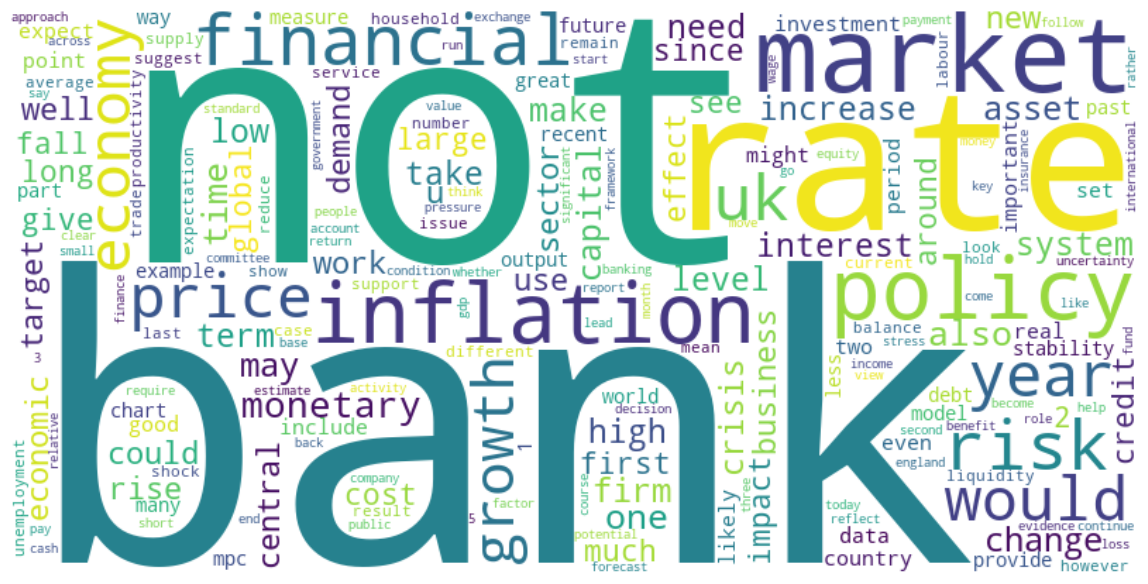

In [153]:
# Create wordcloud of lemmatised text
plot_top_non_stopwords_wordcloud(boe_speeches['text_lemmatised_str'])

In [154]:
# Define bar chart for top words
def top_words_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    # Set plot size
    plt.figure(figsize=(12, 8))
    
    # Plot
    sns.barplot(x=y, y=x)
    
    # Set label font sizes
    plt.xlabel('Count', fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.title('Top Non-Stopword Words', fontsize=16)
    plt.tight_layout()
    plt.show()

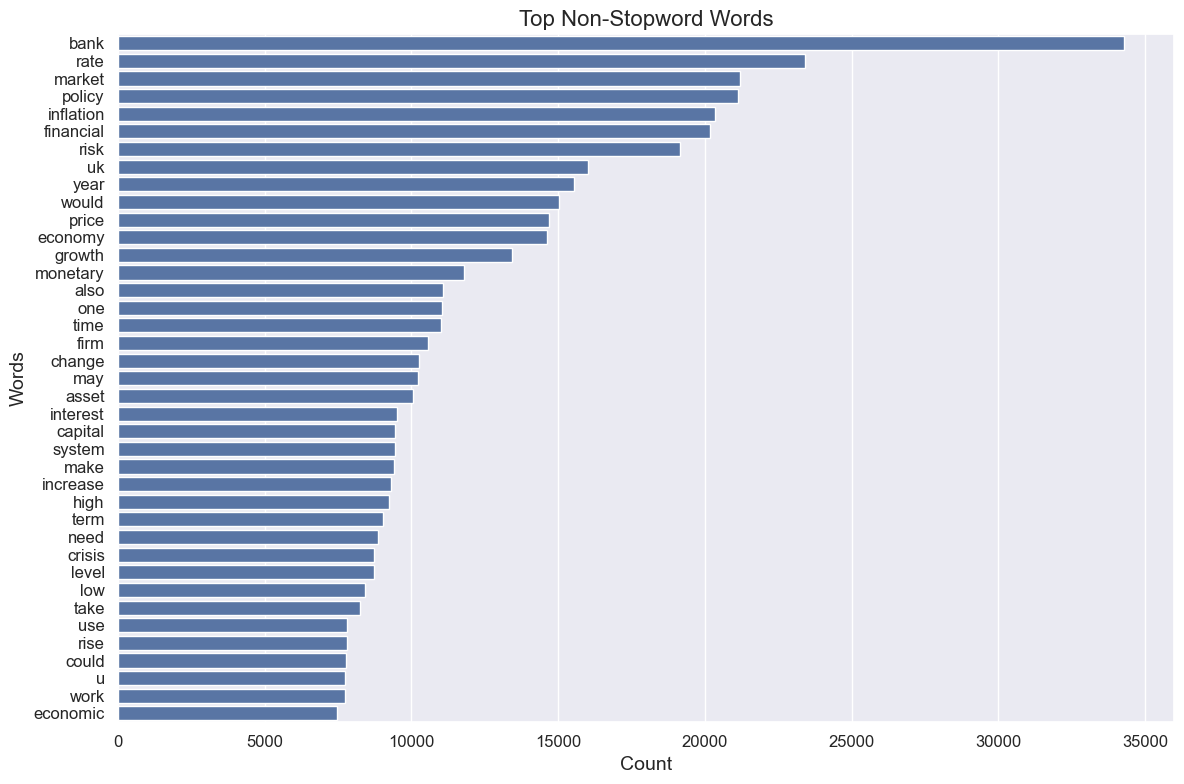

In [155]:
# Create bar chart to show top words
top_words_barchart(boe_speeches['text_lemmatised_str'])

In [156]:
# Define bar chart for top word groups
def top_word_group_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

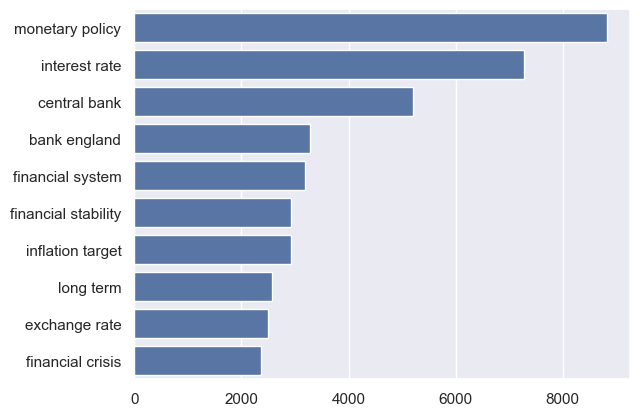

In [157]:
# Plot top phrases with 2 words
top_word_group_barchart(boe_speeches['text_lemmatised_str'],2)

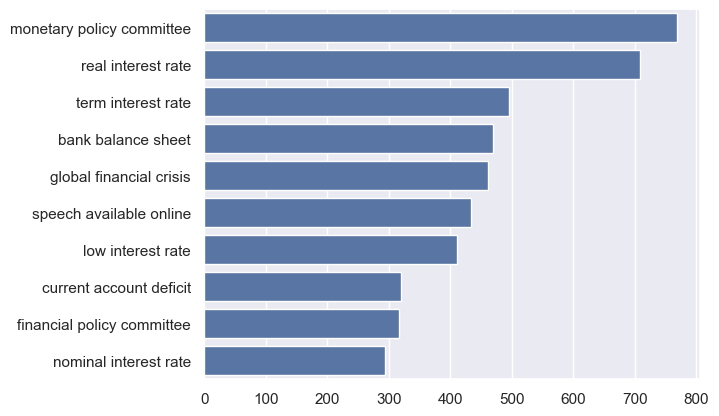

In [158]:
# Plot top phrases with 3 words
top_word_group_barchart(boe_speeches['text_lemmatised_str'],3)

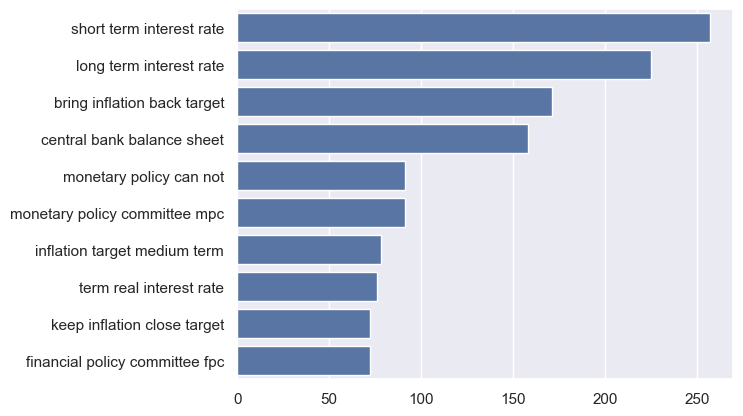

In [159]:
# Plot top phrases with 4 words
top_word_group_barchart(boe_speeches['text_lemmatised_str'],4)

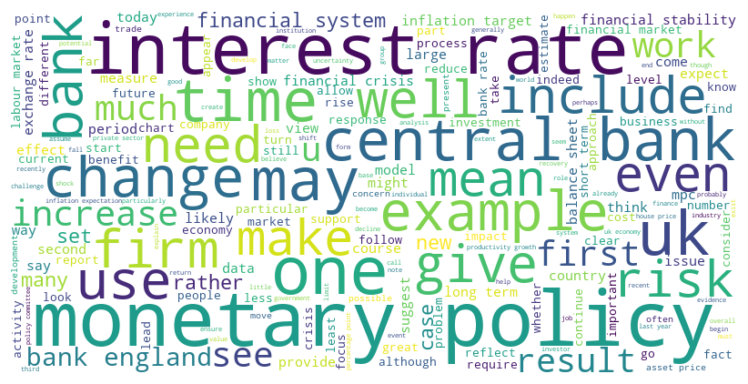

In [160]:
# Convert tokens into a single string.
boe_speeches_text = ' '.join(boe_speeches['text_lemmatised_str'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(boe_speeches_text)

# Display the word cloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')

# Hide the axis.
plt.axis('off') 

# Dispaly the word cloud.
plt.tight_layout()
plt.show()

### 3.3. Sentiment Analysis with BoE Sentiment Wordlist for BoE speeches

In [163]:
# Prepare the lexicon
sentiment_lexicon = sentiment_lexicon.copy()

# Define categories
categories = [
     'Negative',
     'Positive',
     'Uncertainty',
     'Litigious',
     'Strong',
     'Weak',
     'Constraining',
 ]

# Create dictionary of categories, containing words that belong to that category based on your sentiment lexicon.
word_sets = {
    cat: set(sentiment_lexicon.loc[sentiment_lexicon[cat] == 1, 'Word'].str.lower())
    for cat in categories
}

In [164]:
# Define function to apply the lexicon to the text
def lexicon_counts(tokens):
    return pd.Series({
        cat: sum(t in word_sets[cat] for t in tokens)
        for cat in categories
    })

# Compute counts and add new columns for each category
boe_speeches = pd.concat(
    [boe_speeches, boe_speeches['text_lemmatised'].apply(lexicon_counts)], axis=1
 )

boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ...                                    text_lemmatised  \
4961    1998-09  1998  ...  [thank, chairman, actually, pleased, opportuni...   
4962    1998-10  1998  ...  [great, pleasure, beautiful, city, bruges, hon...   
4963    1998-10  1998  ...  [industry, suffer, volatility, british, econom...   
4964    1998-11  1998  ...  [topic, evening, use, forecast, economic, poli...   
4965    1998-11  1998  ...  [six, year, ago, week, sterling, leave, exchan...   

                                    text_lemmatised_str word_count Negative  \
4961  thank chairman actually pleased opportunity re...       1162       62   
4962  great pleasure beautiful city bruges honour op...       2108       80   
4963  industry suffer volatility british economy pas...       1240       63   
4964  topic evening use forecast economic policy mak...       2380       79   
4965  six year ago week sterling leave exchange rate...       2580      102   

      Positive  Uncertainty  Litigious  Strong  Weak  Constraining  
4961        39           24          3      14    16             2  
4962        88           51          6      10    28            17  
4963        32           49          2       3    15             6  
4964        42           91         12      14    42            15  
4965        46          113         22      13    48            12  

[5 rows x 22 columns]

In [165]:
# Calculate the sentiment score by subtracting the negative score from the positive score and dividing by the total number of words
boe_speeches['sentiment_score_lexicon'] = (boe_speeches['Positive'] - boe_speeches['Negative'])/ boe_speeches['word_count']

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ...                                text_lemmatised_str  \
4961    1998-09  1998  ...  thank chairman actually pleased opportunity re...   
4962    1998-10  1998  ...  great pleasure beautiful city bruges honour op...   
4963    1998-10  1998  ...  industry suffer volatility british economy pas...   
4964    1998-11  1998  ...  topic evening use forecast economic policy mak...   
4965    1998-11  1998  ...  six year ago week sterling leave exchange rate...   

     word_count Negative Positive  Uncertainty  Litigious  Strong  Weak  \
4961       1162       62       39           24          3      14    16   
4962       2108       80       88           51          6      10    28   
4963       1240       63       32           49          2       3    15   
4964       2380       79       42           91         12      14    42   
4965       2580      102       46          113         22      13    48   

      Constraining  sentiment_score_lexicon  
4961             2                -0.019793  
4962            17                 0.003795  
4963             6                -0.025000  
4964            15                -0.015546  
4965            12                -0.021705  

[5 rows x 23 columns]

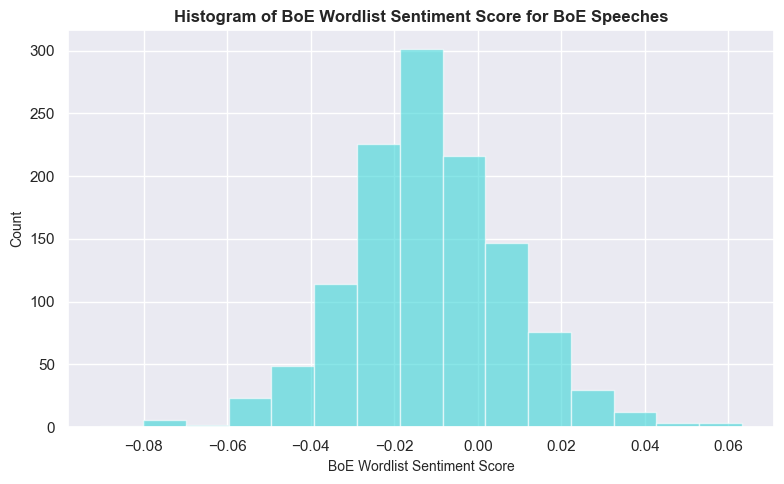

In [166]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15
# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['sentiment_score_lexicon'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('BoE Wordlist Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of BoE Wordlist Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

In [167]:
# View distribution of sentiment scores
boe_speeches['sentiment_score_lexicon'].describe()

count    1209.000000
mean       -0.011770
std         0.019079
min        -0.090339
25%        -0.023582
50%        -0.012294
75%        -0.000405
max         0.063218
Name: sentiment_score_lexicon, dtype: float64

In [168]:
# Standardise the sentiment score
# Calculate mean and standard deviation
mean_score = boe_speeches['sentiment_score_lexicon'].mean()
std_score = boe_speeches['sentiment_score_lexicon'].std()

# Create a new column for standardized scores
boe_speeches['sentiment_score_lexicon_std'] = (boe_speeches['sentiment_score_lexicon'] - mean_score) / std_score

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... word_count Negative Positive Uncertainty  \
4961    1998-09  1998  ...       1162       62       39          24   
4962    1998-10  1998  ...       2108       80       88          51   
4963    1998-10  1998  ...       1240       63       32          49   
4964    1998-11  1998  ...       2380       79       42          91   
4965    1998-11  1998  ...       2580      102       46         113   

      Litigious  Strong  Weak  Constraining  sentiment_score_lexicon  \
4961          3      14    16             2                -0.019793   
4962          6      10    28            17                 0.003795   
4963          2       3    15             6                -0.025000   
4964         12      14    42            15                -0.015546   
4965         22      13    48            12                -0.021705   

      sentiment_score_lexicon_std  
4961                    -0.420532  
4962                     0.815821  
4963                    -0.693424  
4964                    -0.197920  
4965                    -0.520744  

[5 rows x 24 columns]

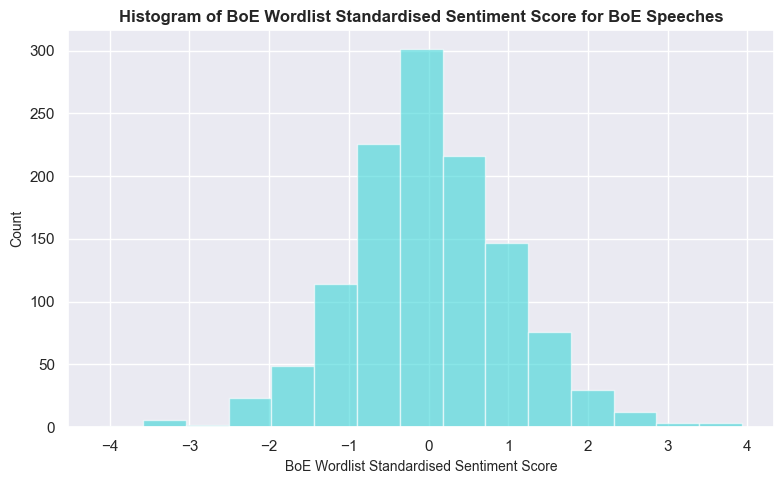

In [169]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15
# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['sentiment_score_lexicon_std'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('BoE Wordlist Standardised Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of BoE Wordlist Standardised Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

In [170]:
# View distribution of sentiment scores
boe_speeches['sentiment_score_lexicon_std'].describe()

count    1.209000e+03
mean     9.403378e-17
std      1.000000e+00
min     -4.118045e+00
25%     -6.190852e-01
50%     -2.745708e-02
75%      5.956975e-01
max      3.930394e+00
Name: sentiment_score_lexicon_std, dtype: float64

In [171]:
# Categories sentiment according to sentiment score
def categorise_sentiment(sentiment_score):
    if sentiment_score >= 1:
        return 'Positive'
    elif sentiment_score <= -1:
        return 'Negative'
    else:
        return 'Neutral'

In [172]:
# Apply the sentiment labels to speeches
boe_speeches['lexicon_label'] = boe_speeches['sentiment_score_lexicon_std'].apply(categorise_sentiment)

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... Negative Positive Uncertainty Litigious  Strong  \
4961    1998-09  1998  ...       62       39          24         3      14   
4962    1998-10  1998  ...       80       88          51         6      10   
4963    1998-10  1998  ...       63       32          49         2       3   
4964    1998-11  1998  ...       79       42          91        12      14   
4965    1998-11  1998  ...      102       46         113        22      13   

      Weak  Constraining  sentiment_score_lexicon  \
4961    16             2                -0.019793   
4962    28            17                 0.003795   
4963    15             6                -0.025000   
4964    42            15                -0.015546   
4965    48            12                -0.021705   

      sentiment_score_lexicon_std  lexicon_label  
4961                    -0.420532        Neutral  
4962                     0.815821        Neutral  
4963                    -0.693424        Neutral  
4964                    -0.197920        Neutral  
4965                    -0.520744        Neutral  

[5 rows x 25 columns]

In [173]:
# Categories sentiment according to percentile thresholds
lower_thresh = boe_speeches['sentiment_score_lexicon_std'].quantile(0.20)
upper_thresh = boe_speeches['sentiment_score_lexicon_std'].quantile(0.80)

def classify_score(z):
    if z >= upper_thresh:
        return 'Positive'
    elif z <= lower_thresh:
        return 'Negative'
    else:
        return 'Neutral'

In [174]:
# Apply the sentiment labels to speeches
boe_speeches['lexicon_label_percentile'] = boe_speeches['sentiment_score_lexicon_std'].apply(classify_score)

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... Positive Uncertainty Litigious Strong  Weak  \
4961    1998-09  1998  ...       39          24         3     14    16   
4962    1998-10  1998  ...       88          51         6     10    28   
4963    1998-10  1998  ...       32          49         2      3    15   
4964    1998-11  1998  ...       42          91        12     14    42   
4965    1998-11  1998  ...       46         113        22     13    48   

      Constraining  sentiment_score_lexicon  sentiment_score_lexicon_std  \
4961             2                -0.019793                    -0.420532   
4962            17                 0.003795                     0.815821   
4963             6                -0.025000                    -0.693424   
4964            15                -0.015546                    -0.197920   
4965            12                -0.021705                    -0.520744   

      lexicon_label  lexicon_label_percentile  
4961        Neutral                   Neutral  
4962        Neutral                  Positive  
4963        Neutral                   Neutral  
4964        Neutral                   Neutral  
4965        Neutral                   Neutral  

[5 rows x 26 columns]

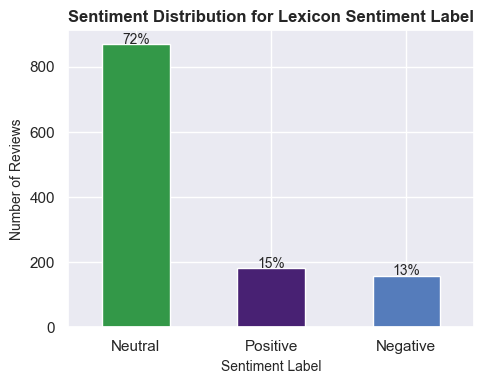

In [175]:
# Plot the sentiments distribution for lexicon label
sentiment_labels_lexicon = boe_speeches['lexicon_label']

# Create a figure
plt.figure(figsize=(5, 4))

# Calculate the counts and percentages
sentiment_counts = pd.Series(sentiment_labels_lexicon.value_counts())
sentiment_percentages = sentiment_counts / sentiment_counts.sum() * 100  # Calculate percentages

# Plot the bar chart
sentiment_counts.plot(kind='bar', color=['#339848', '#482173', '#557cbb'])

# Add labels.
plt.title('Sentiment Distribution for Lexicon Sentiment Label', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment Label', fontsize=10)
plt.ylabel('Number of Reviews', fontsize=10)
plt.xticks(rotation=0)

# Annotate the bars with percentages
for index, value in enumerate(sentiment_counts):
    plt.text(index, value + 0.5, f'{sentiment_percentages[index]:.0f}%', ha='center', fontsize=10)

# Save the plot.
# plt.savefig('Fig_Sentiment_Reviews.png', dpi=500, bbox_inches='tight')

# Display the plot.
plt.tight_layout()
plt.show()

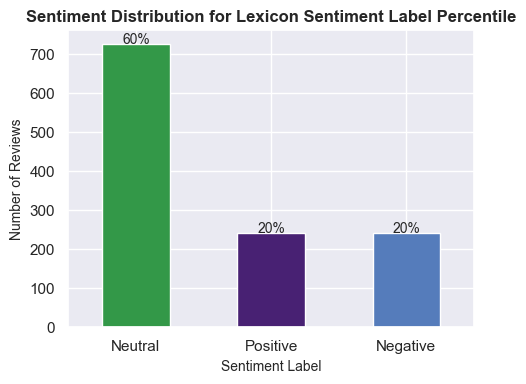

In [176]:
# Plot the sentiments distribution for lexicon percentile
sentiment_labels_lexicon_percentile = boe_speeches['lexicon_label_percentile']

# Create a figure
plt.figure(figsize=(5, 4))

# Calculate the counts and percentages
sentiment_counts = pd.Series(sentiment_labels_lexicon_percentile.value_counts())
sentiment_percentages = sentiment_counts / sentiment_counts.sum() * 100  # Calculate percentages

# Plot the bar chart
sentiment_counts.plot(kind='bar', color=['#339848', '#482173', '#557cbb'])

# Add labels.
plt.title('Sentiment Distribution for Lexicon Sentiment Label Percentile', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment Label', fontsize=10)
plt.ylabel('Number of Reviews', fontsize=10)
plt.xticks(rotation=0)

# Annotate the bars with percentages
for index, value in enumerate(sentiment_counts):
    plt.text(index, value + 0.5, f'{sentiment_percentages[index]:.0f}%', ha='center', fontsize=10)

# Save the plot.
# plt.savefig('Fig_Sentiment_Reviews.png', dpi=500, bbox_inches='tight')

# Display the plot.
plt.tight_layout()
plt.show()

### 3.4. Sentiment Analysis with Custom Dictionary

In [178]:
# Prepare the lexicon
custom = custom_dict.copy()

categories = [
     'negative_custom',
     'positive_custom',
     'uncertainty_custom'
 ]

word_sets = {
    cat: set(custom.loc[custom[cat] == 1, 'Word'].str.lower())
    for cat in categories
}

In [179]:
# Compute counts and add new columns for each category
boe_speeches = pd.concat(
    [boe_speeches, boe_speeches['text_lemmatised'].apply(lexicon_counts)], axis=1
 )

boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... Strong Weak Constraining sentiment_score_lexicon  \
4961    1998-09  1998  ...     14   16            2               -0.019793   
4962    1998-10  1998  ...     10   28           17                0.003795   
4963    1998-10  1998  ...      3   15            6               -0.025000   
4964    1998-11  1998  ...     14   42           15               -0.015546   
4965    1998-11  1998  ...     13   48           12               -0.021705   

      sentiment_score_lexicon_std  lexicon_label  lexicon_label_percentile  \
4961                    -0.420532        Neutral                   Neutral   
4962                     0.815821        Neutral                  Positive   
4963                    -0.693424        Neutral                   Neutral   
4964                    -0.197920        Neutral                   Neutral   
4965                    -0.520744        Neutral                   Neutral   

      negative_custom  positive_custom  uncertainty_custom  
4961                6                0                   9  
4962                3                0                  12  
4963                4                3                   4  
4964                5                0                  86  
4965               19                0                  24  

[5 rows x 29 columns]

In [180]:
# Calculate the sentiment score by subtracting the negative score from the positive score and dividing by total number of words
boe_speeches['sentiment_score_custom'] = (boe_speeches['positive_custom'] - boe_speeches['negative_custom'])/ boe_speeches['word_count']

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... Weak Constraining sentiment_score_lexicon  \
4961    1998-09  1998  ...   16            2               -0.019793   
4962    1998-10  1998  ...   28           17                0.003795   
4963    1998-10  1998  ...   15            6               -0.025000   
4964    1998-11  1998  ...   42           15               -0.015546   
4965    1998-11  1998  ...   48           12               -0.021705   

     sentiment_score_lexicon_std  lexicon_label  lexicon_label_percentile  \
4961                   -0.420532        Neutral                   Neutral   
4962                    0.815821        Neutral                  Positive   
4963                   -0.693424        Neutral                   Neutral   
4964                   -0.197920        Neutral                   Neutral   
4965                   -0.520744        Neutral                   Neutral   

      negative_custom  positive_custom  uncertainty_custom  \
4961                6                0                   9   
4962                3                0                  12   
4963                4                3                   4   
4964                5                0                  86   
4965               19                0                  24   

      sentiment_score_custom  
4961               -0.005164  
4962               -0.001423  
4963               -0.000806  
4964               -0.002101  
4965               -0.007364  

[5 rows x 30 columns]

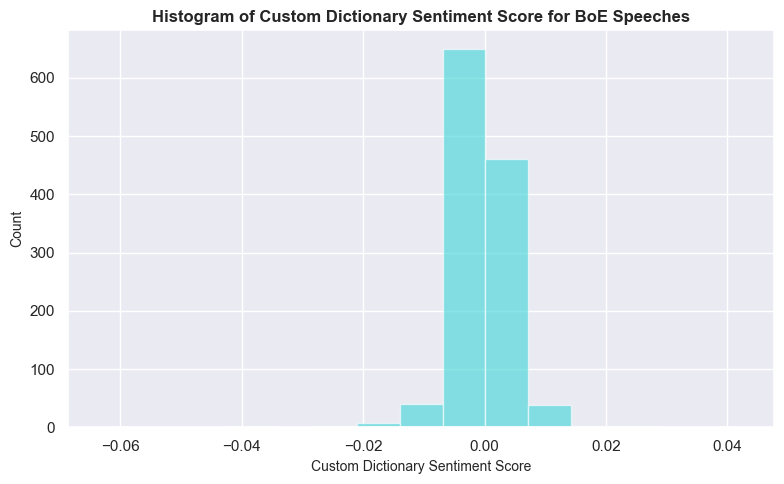

In [181]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['sentiment_score_custom'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Custom Dictionary Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Custom Dictionary Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

In [182]:
# View distribution of sentiment scores
boe_speeches['sentiment_score_custom'].describe()

count    1209.000000
mean       -0.000129
std         0.004979
min        -0.063301
25%        -0.001594
50%         0.000000
75%         0.001336
max         0.042424
Name: sentiment_score_custom, dtype: float64

In [183]:
# Standardise the sentiment score
# Calculate mean and standard deviation
mean_score_custom = boe_speeches['sentiment_score_custom'].mean()
std_score_custom = boe_speeches['sentiment_score_custom'].std()

# Create a new column for standardized scores
boe_speeches['sentiment_score_custom_std'] = (boe_speeches['sentiment_score_custom'] - mean_score_custom) / std_score_custom

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... Constraining sentiment_score_lexicon  \
4961    1998-09  1998  ...            2               -0.019793   
4962    1998-10  1998  ...           17                0.003795   
4963    1998-10  1998  ...            6               -0.025000   
4964    1998-11  1998  ...           15               -0.015546   
4965    1998-11  1998  ...           12               -0.021705   

     sentiment_score_lexicon_std lexicon_label  lexicon_label_percentile  \
4961                   -0.420532       Neutral                   Neutral   
4962                    0.815821       Neutral                  Positive   
4963                   -0.693424       Neutral                   Neutral   
4964                   -0.197920       Neutral                   Neutral   
4965                   -0.520744       Neutral                   Neutral   

      negative_custom  positive_custom  uncertainty_custom  \
4961                6                0                   9   
4962                3                0                  12   
4963                4                3                   4   
4964                5                0                  86   
4965               19                0                  24   

      sentiment_score_custom  sentiment_score_custom_std  
4961               -0.005164                   -1.011042  
4962               -0.001423                   -0.259869  
4963               -0.000806                   -0.136018  
4964               -0.002101                   -0.395969  
4965               -0.007364                   -1.453032  

[5 rows x 31 columns]

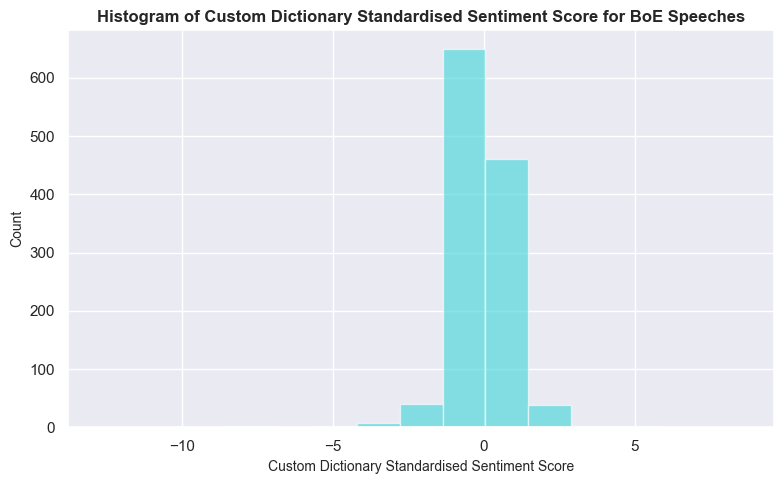

In [184]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['sentiment_score_custom_std'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Custom Dictionary Standardised Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Custom Dictionary Standardised Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

In [185]:
# View distribution of sentiment scores
boe_speeches['sentiment_score_custom_std'].describe()

count    1.209000e+03
mean    -3.526267e-17
std      1.000000e+00
min     -1.268676e+01
25%     -2.941055e-01
50%      2.594062e-02
75%      2.943388e-01
max      8.545956e+00
Name: sentiment_score_custom_std, dtype: float64

In [186]:
# Apply the sentiment labels to speeches
boe_speeches['custom_label'] = boe_speeches['sentiment_score_custom_std'].apply(categorise_sentiment)

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... sentiment_score_lexicon  \
4961    1998-09  1998  ...               -0.019793   
4962    1998-10  1998  ...                0.003795   
4963    1998-10  1998  ...               -0.025000   
4964    1998-11  1998  ...               -0.015546   
4965    1998-11  1998  ...               -0.021705   

     sentiment_score_lexicon_std lexicon_label lexicon_label_percentile  \
4961                   -0.420532       Neutral                  Neutral   
4962                    0.815821       Neutral                 Positive   
4963                   -0.693424       Neutral                  Neutral   
4964                   -0.197920       Neutral                  Neutral   
4965                   -0.520744       Neutral                  Neutral   

      negative_custom  positive_custom  uncertainty_custom  \
4961                6                0                   9   
4962                3                0                  12   
4963                4                3                   4   
4964                5                0                  86   
4965               19                0                  24   

      sentiment_score_custom  sentiment_score_custom_std  custom_label  
4961               -0.005164                   -1.011042      Negative  
4962               -0.001423                   -0.259869       Neutral  
4963               -0.000806                   -0.136018       Neutral  
4964               -0.002101                   -0.395969       Neutral  
4965               -0.007364                   -1.453032      Negative  

[5 rows x 32 columns]

In [187]:
# Categories sentiment according to percentile thresholds
lower_thresh = boe_speeches['sentiment_score_custom_std'].quantile(0.20)
upper_thresh = boe_speeches['sentiment_score_custom_std'].quantile(0.80)

In [188]:
# Apply the sentiment labels to speeches
boe_speeches['custom_label_percentile'] = boe_speeches['sentiment_score_custom_std'].apply(classify_score)

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... sentiment_score_lexicon_std lexicon_label  \
4961    1998-09  1998  ...                   -0.420532       Neutral   
4962    1998-10  1998  ...                    0.815821       Neutral   
4963    1998-10  1998  ...                   -0.693424       Neutral   
4964    1998-11  1998  ...                   -0.197920       Neutral   
4965    1998-11  1998  ...                   -0.520744       Neutral   

     lexicon_label_percentile negative_custom  positive_custom  \
4961                  Neutral               6                0   
4962                 Positive               3                0   
4963                  Neutral               4                3   
4964                  Neutral               5                0   
4965                  Neutral              19                0   

      uncertainty_custom  sentiment_score_custom  sentiment_score_custom_std  \
4961                   9               -0.005164                   -1.011042   
4962                  12               -0.001423                   -0.259869   
4963                   4               -0.000806                   -0.136018   
4964                  86               -0.002101                   -0.395969   
4965                  24               -0.007364                   -1.453032   

      custom_label  custom_label_percentile  
4961      Negative                 Negative  
4962       Neutral                  Neutral  
4963       Neutral                  Neutral  
4964       Neutral                 Negative  
4965      Negative                 Negative  

[5 rows x 33 columns]

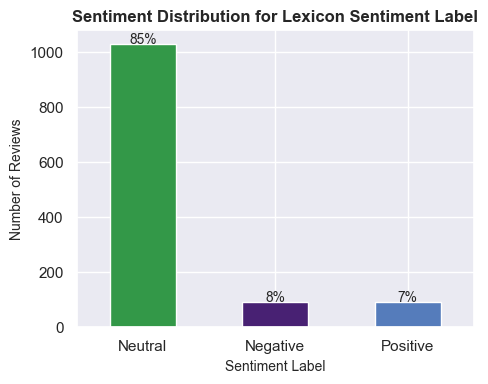

In [189]:
# Plot the sentiments distribution for lexicon label
sentiment_labels_custom = boe_speeches['custom_label']

# Create a figure
plt.figure(figsize=(5, 4))

# Calculate the counts and percentages
sentiment_counts = pd.Series(sentiment_labels_custom.value_counts())
sentiment_percentages = sentiment_counts / sentiment_counts.sum() * 100  # Calculate percentages

# Plot the bar chart
sentiment_counts.plot(kind='bar', color=['#339848', '#482173', '#557cbb'])

# Add labels.
plt.title('Sentiment Distribution for Lexicon Sentiment Label', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment Label', fontsize=10)
plt.ylabel('Number of Reviews', fontsize=10)
plt.xticks(rotation=0)

# Annotate the bars with percentages
for index, value in enumerate(sentiment_counts):
    plt.text(index, value + 0.5, f'{sentiment_percentages[index]:.0f}%', ha='center', fontsize=10)

# Save the plot.
# plt.savefig('Fig_Sentiment_Reviews.png', dpi=500, bbox_inches='tight')

# Display the plot.
plt.tight_layout()
plt.show()

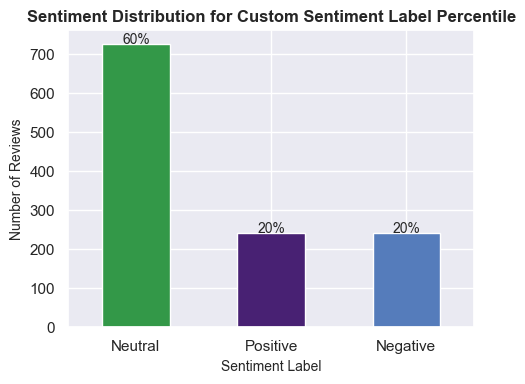

In [190]:
# Plot the sentiments distribution for lexicon percentile
sentiment_labels_custom_percentile = boe_speeches['custom_label_percentile']

# Create a figure
plt.figure(figsize=(5, 4))

# Calculate the counts and percentages
sentiment_counts = pd.Series(sentiment_labels_lexicon_percentile.value_counts())
sentiment_percentages = sentiment_counts / sentiment_counts.sum() * 100  # Calculate percentages

# Plot the bar chart
sentiment_counts.plot(kind='bar', color=['#339848', '#482173', '#557cbb'])

# Add labels.
plt.title('Sentiment Distribution for Custom Sentiment Label Percentile', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment Label', fontsize=10)
plt.ylabel('Number of Reviews', fontsize=10)
plt.xticks(rotation=0)

# Annotate the bars with percentages
for index, value in enumerate(sentiment_counts):
    plt.text(index, value + 0.5, f'{sentiment_percentages[index]:.0f}%', ha='center', fontsize=10)

# Save the plot.
# plt.savefig('Fig_Sentiment_Reviews.png', dpi=500, bbox_inches='tight')

# Display the plot.
plt.tight_layout()
plt.show()

**Observation**: The custom lexicon gives interesting results, however, it is limiting to only include 39 words in the analysis.

### 3.5. Sentiment Analysis with FinBERT for BoE speeches using yiyanghkurts model

In [193]:
# Define a function to predict probabilities in batches
def predict_batch(texts, tokenizer, model, max_length=128):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')  # Tokenize batch of texts
    inputs = {k: v.to(device) for k, v in inputs.items()}                 # Move inputs to the device (GPU or CPU)
    with torch.no_grad():                                                 # Get model outputs without computing gradients
        outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)                              # Convert logits to probabilities
    return probs.cpu().numpy()

In [194]:
# Check the order of labels in the model
model_yiyang.config.id2label

{0: 'Neutral', 1: 'Positive', 2: 'Negative'}

In [195]:
# Column that the model should be applied to
texts = boe_speeches['text_lemmatised'].astype(str).tolist()

# Specify batch size for efficiency
batch_size = 32
all_probs = []

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i + batch_size]
    batch_probs = predict_batch(batch_texts, tokenizer_yiyang, model_yiyang)
    all_probs.extend(batch_probs)

# Store the predicted probabilities back into your DataFrame
boe_speeches['yiyang_probs'] = all_probs

# Extract top labels using the order established above
labels = ['Neutral', 'Positive', 'Negative']

def get_probs_yiyang_dict(probs):
    # Assumes probs is an array/list like [neutral_score, positive_score, negative_score]
    return {
        'yiyang_neutral': probs[0],
        'yiyang_positive': probs[1],
        'yiyang_negative': probs[2]
    }

def get_top_label(probs):
    idx = probs.argmax()
    return labels[idx], probs.max()

In [196]:
# Create a DataFrame with all class probabilities
probs_yiyang = boe_speeches['yiyang_probs'].apply(lambda x: get_probs_yiyang_dict(x)).apply(pd.Series)

# Assign back to your main DataFrame
boe_speeches = pd.concat([boe_speeches, probs_yiyang], axis=1)

# Apply and extract label + confidence
boe_speeches[['yiyang_label', 'yiyang_confidence']] = boe_speeches['yiyang_probs'].apply(lambda x: get_top_label(x)).apply(pd.Series)

# Now, your DataFrame has the probabilities, top label, and confidence score
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... sentiment_score_custom sentiment_score_custom_std  \
4961    1998-09  1998  ...              -0.005164                  -1.011042   
4962    1998-10  1998  ...              -0.001423                  -0.259869   
4963    1998-10  1998  ...              -0.000806                  -0.136018   
4964    1998-11  1998  ...              -0.002101                  -0.395969   
4965    1998-11  1998  ...              -0.007364                  -1.453032   

     custom_label custom_label_percentile  \
4961     Negative                Negative   
4962      Neutral                 Neutral   
4963      Neutral                 Neutral   
4964      Neutral                Negative   
4965     Negative                Negative   

                                  yiyang_probs  yiyang_neutral  \
4961     [0.4900095, 0.5094528, 0.00053772976]        0.490009   
4962    [0.969261, 0.030696781, 4.2198746e-05]        0.969261   
4963      [0.37933072, 0.021060491, 0.5996088]        0.379331   
4964     [0.9847193, 0.0149205, 0.00036025542]        0.984719   
4965  [0.9990752, 0.0009056315, 1.9160354e-05]        0.999075   

      yiyang_positive  yiyang_negative  yiyang_label  yiyang_confidence  
4961         0.509453         0.000538      Positive           0.509453  
4962         0.030697         0.000042       Neutral           0.969261  
4963         0.021060         0.599609      Negative           0.599609  
4964         0.014921         0.000360       Neutral           0.984719  
4965         0.000906         0.000019       Neutral           0.999075  

[5 rows x 39 columns]

In [197]:
# Define weights 
weights = {
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
}

In [198]:
# Define function to calculate one sentiment score
def compute_tone_score(probs):
    class_labels = ['Neutral', 'Positive', 'Negative']
    prob_dict = dict(zip(class_labels, probs))
    return (
        prob_dict['Positive'] * weights['Positive'] +
        prob_dict['Neutral'] * weights['Neutral'] +
        prob_dict['Negative'] * weights['Negative']
    )

In [199]:
# Apply to all rows
boe_speeches['sentiment_score_yiyang'] = boe_speeches['yiyang_probs'].apply(compute_tone_score)

# View the dataframe
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... sentiment_score_custom_std custom_label  \
4961    1998-09  1998  ...                  -1.011042     Negative   
4962    1998-10  1998  ...                  -0.259869      Neutral   
4963    1998-10  1998  ...                  -0.136018      Neutral   
4964    1998-11  1998  ...                  -0.395969      Neutral   
4965    1998-11  1998  ...                  -1.453032     Negative   

     custom_label_percentile                              yiyang_probs  \
4961                Negative     [0.4900095, 0.5094528, 0.00053772976]   
4962                 Neutral    [0.969261, 0.030696781, 4.2198746e-05]   
4963                 Neutral      [0.37933072, 0.021060491, 0.5996088]   
4964                Negative     [0.9847193, 0.0149205, 0.00036025542]   
4965                Negative  [0.9990752, 0.0009056315, 1.9160354e-05]   

      yiyang_neutral  yiyang_positive  yiyang_negative  yiyang_label  \
4961        0.490009         0.509453         0.000538      Positive   
4962        0.969261         0.030697         0.000042       Neutral   
4963        0.379331         0.021060         0.599609      Negative   
4964        0.984719         0.014921         0.000360       Neutral   
4965        0.999075         0.000906         0.000019       Neutral   

      yiyang_confidence  sentiment_score_yiyang  
4961           0.509453                0.508915  
4962           0.969261                0.030655  
4963           0.599609               -0.578548  
4964           0.984719                0.014560  
4965           0.999075                0.000886  

[5 rows x 40 columns]

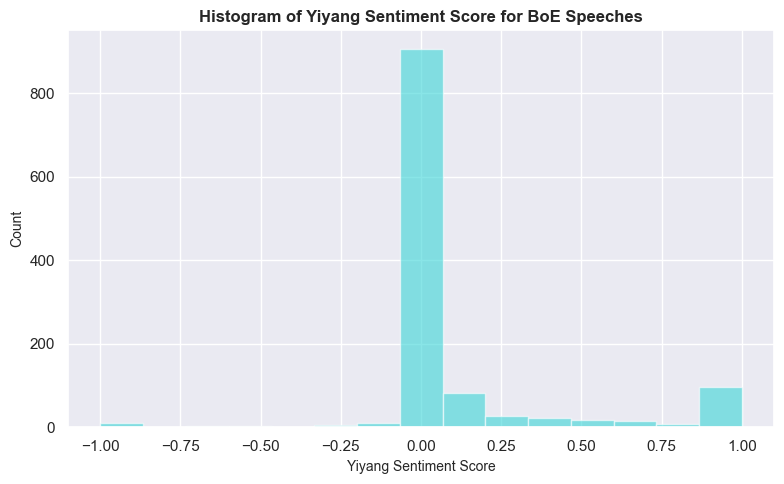

In [200]:
# Plot a histogram of the confidence score for BoE speeches
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the plot.
n, bins, patches = plt.hist(boe_speeches['sentiment_score_yiyang'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Yiyang Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Yiyang Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

In [201]:
# Standardise the sentiment score
# Calculate mean and standard deviation
mean_score_yiyang = boe_speeches['sentiment_score_yiyang'].mean()
std_score_yiyang = boe_speeches['sentiment_score_yiyang'].std()

# Create a new column for standardized scores
boe_speeches['sentiment_score_yiyang_std'] = (boe_speeches['sentiment_score_yiyang'] - mean_score_yiyang) / std_score_yiyang

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... custom_label custom_label_percentile  \
4961    1998-09  1998  ...     Negative                Negative   
4962    1998-10  1998  ...      Neutral                 Neutral   
4963    1998-10  1998  ...      Neutral                 Neutral   
4964    1998-11  1998  ...      Neutral                Negative   
4965    1998-11  1998  ...     Negative                Negative   

                                  yiyang_probs yiyang_neutral  \
4961     [0.4900095, 0.5094528, 0.00053772976]       0.490009   
4962    [0.969261, 0.030696781, 4.2198746e-05]       0.969261   
4963      [0.37933072, 0.021060491, 0.5996088]       0.379331   
4964     [0.9847193, 0.0149205, 0.00036025542]       0.984719   
4965  [0.9990752, 0.0009056315, 1.9160354e-05]       0.999075   

      yiyang_positive  yiyang_negative  yiyang_label  yiyang_confidence  \
4961         0.509453         0.000538      Positive           0.509453   
4962         0.030697         0.000042       Neutral           0.969261   
4963         0.021060         0.599609      Negative           0.599609   
4964         0.014921         0.000360       Neutral           0.984719   
4965         0.000906         0.000019       Neutral           0.999075   

      sentiment_score_yiyang  sentiment_score_yiyang_std  
4961                0.508915                    1.291954  
4962                0.030655                   -0.260091  
4963               -0.578548                   -2.237069  
4964                0.014560                   -0.312321  
4965                0.000886                   -0.356694  

[5 rows x 41 columns]

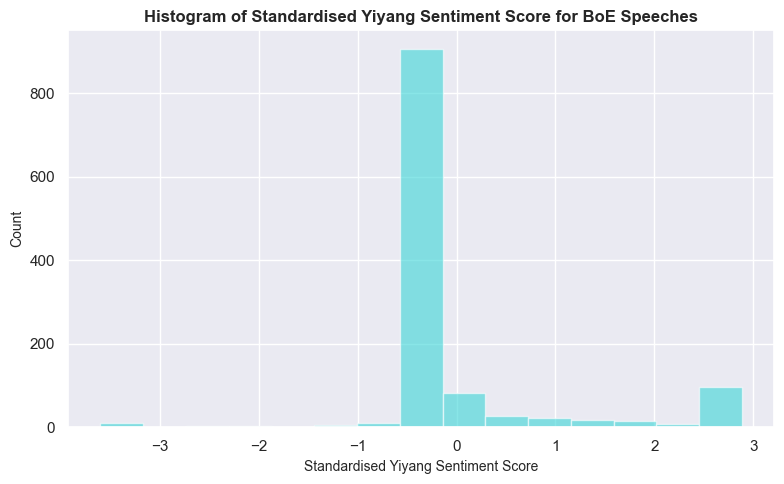

In [202]:
# Plot a histogram of the standardised sentiment score for BoE speeches
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the plot.
n, bins, patches = plt.hist(boe_speeches['sentiment_score_yiyang_std'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Standardised Yiyang Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Standardised Yiyang Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

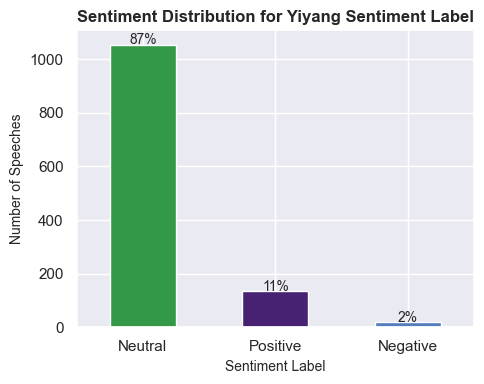

In [203]:
# Plot the sentiments distribution for yiyang
sentiment_labels_yiyang = boe_speeches['yiyang_label']

# Create a figure
plt.figure(figsize=(5, 4))

# Calculate the counts and percentages
sentiment_counts = pd.Series(sentiment_labels_yiyang.value_counts())
sentiment_percentages = sentiment_counts / sentiment_counts.sum() * 100  # Calculate percentages

# Plot the bar chart
sentiment_counts.plot(kind='bar', color=['#339848', '#482173', '#557cbb'])

# Add labels.
plt.title('Sentiment Distribution for Yiyang Sentiment Label', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment Label', fontsize=10)
plt.ylabel('Number of Speeches', fontsize=10)
plt.xticks(rotation=0)

# Annotate the bars with percentages
for index, value in enumerate(sentiment_counts):
    plt.text(index, value + 0.5, f'{sentiment_percentages[index]:.0f}%', ha='center', fontsize=10)

# Save the plot.
# plt.savefig('Fig_Sentiment_Reviews.png', dpi=500, bbox_inches='tight')

# Display the plot.
plt.tight_layout()
plt.show()

In [204]:
# View the weighted Sentiment scores.
boe_speeches['sentiment_score_yiyang'].describe()

count    1209.000000
mean        0.110801
std         0.308149
min        -0.998919
25%         0.000640
50%         0.004308
75%         0.043896
max         1.000000
Name: sentiment_score_yiyang, dtype: float64

### 3.6. GPT Results

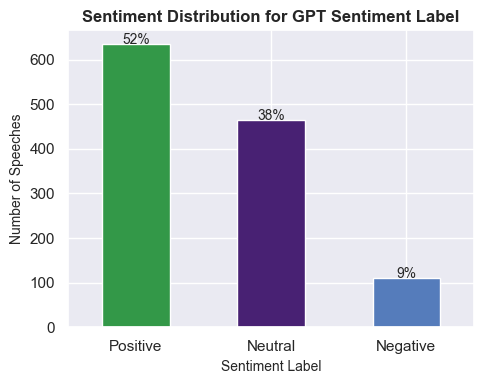

In [206]:
# Plot the sentiments distribution for yiyang
sentiment_labels_gpt = gpt_sentiment['Gpt_sentiment']

# Create a figure
plt.figure(figsize=(5, 4))

# Calculate the counts and percentages
sentiment_counts = pd.Series(sentiment_labels_gpt.value_counts())
sentiment_percentages = sentiment_counts / sentiment_counts.sum() * 100  # Calculate percentages

# Plot the bar chart
sentiment_counts.plot(kind='bar', color=['#339848', '#482173', '#557cbb'])

# Add labels.
plt.title('Sentiment Distribution for GPT Sentiment Label', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment Label', fontsize=10)
plt.ylabel('Number of Speeches', fontsize=10)
plt.xticks(rotation=0)

# Annotate the bars with percentages
for index, value in enumerate(sentiment_counts):
    plt.text(index, value + 0.5, f'{sentiment_percentages[index]:.0f}%', ha='center', fontsize=10)

# Save the plot.
# plt.savefig('Fig_Sentiment_Reviews.png', dpi=500, bbox_inches='tight')

# Display the plot.
plt.tight_layout()
plt.show()

### 3.6. Compare sentiment scores

Create a new dataframe with only relevant indices.

In [209]:
# Display all column names.
boe_speeches.columns

Index(['reference', 'country', 'date', 'title', 'author', 'is_gov', 'text',
       'date_format', 'year_month', 'year', 'text_cleaned', 'text_tokenised',
       'text_lemmatised', 'text_lemmatised_str', 'word_count', 'Negative',
       'Positive', 'Uncertainty', 'Litigious', 'Strong', 'Weak',
       'Constraining', 'sentiment_score_lexicon',
       'sentiment_score_lexicon_std', 'lexicon_label',
       'lexicon_label_percentile', 'negative_custom', 'positive_custom',
       'uncertainty_custom', 'sentiment_score_custom',
       'sentiment_score_custom_std', 'custom_label', 'custom_label_percentile',
       'yiyang_probs', 'yiyang_neutral', 'yiyang_positive', 'yiyang_negative',
       'yiyang_label', 'yiyang_confidence', 'sentiment_score_yiyang',
       'sentiment_score_yiyang_std'],
      dtype='object')

In [210]:
# Create a new DataFrame with all sentiment scores to include for comparison.
boe_speeches_sentiment = boe_speeches[['reference', 'country', 'date', 'title', 'author', 'is_gov', 'text',
                                       'date_format', 'year_month', 'year', 'text_lemmatised', 'text_lemmatised_str',
                                       'sentiment_score_lexicon_std', 'lexicon_label', 'lexicon_label_percentile', 
                                       'sentiment_score_custom_std', 'custom_label', 'custom_label_percentile',
                                       'sentiment_score_yiyang_std', 'yiyang_label']]

# View the DataFrame.
boe_speeches_sentiment.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year                                    text_lemmatised  \
4961    1998-09  1998  [thank, chairman, actually, pleased, opportuni...   
4962    1998-10  1998  [great, pleasure, beautiful, city, bruges, hon...   
4963    1998-10  1998  [industry, suffer, volatility, british, econom...   
4964    1998-11  1998  [topic, evening, use, forecast, economic, poli...   
4965    1998-11  1998  [six, year, ago, week, sterling, leave, exchan...   

                                    text_lemmatised_str  \
4961  thank chairman actually pleased opportunity re...   
4962  great pleasure beautiful city bruges honour op...   
4963  industry suffer volatility british economy pas...   
4964  topic evening use forecast economic policy mak...   
4965  six year ago week sterling leave exchange rate...   

      sentiment_score_lexicon_std lexicon_label lexicon_label_percentile  \
4961                    -0.420532       Neutral                  Neutral   
4962                     0.815821       Neutral                 Positive   
4963                    -0.693424       Neutral                  Neutral   
4964                    -0.197920       Neutral                  Neutral   
4965                    -0.520744       Neutral                  Neutral   

      sentiment_score_custom_std custom_label custom_label_percentile  \
4961                   -1.011042     Negative                Negative   
4962                   -0.259869      Neutral                 Neutral   
4963                   -0.136018      Neutral                 Neutral   
4964                   -0.395969      Neutral                Negative   
4965                   -1.453032     Negative                Negative   

      sentiment_score_yiyang_std yiyang_label  
4961                    1.291954     Positive  
4962                   -0.260091      Neutral  
4963                   -2.237069     Negative  
4964                   -0.312321      Neutral  
4965                   -0.356694      Neutral

In [211]:
# Concatenate gpt_sentiment
boe_speeches_sentiment_new = pd.merge(boe_speeches_sentiment, gpt_sentiment[['reference', 'Gpt_sentiment']], on='reference', how='left')

# View the DataFrame
boe_speeches_sentiment_new.head()

reference         country       date  \
0  r980915a_BOE  united kingdom 1998-09-15   
1  r981021b_BOE  united kingdom 1998-10-21   
2  r981021a_BOE  united kingdom 1998-10-21   
3  r981101a_BOE  united kingdom 1998-11-01   
4  r981101b_BOE  united kingdom 1998-11-01   

                                               title   author  is_gov  \
0                                             Speech   george       1   
1                                  Britain in Europe   george       1   
2  Impact of the recent turbulence in internation...     king       1   
3        Economic policy, with and without forecasts     budd       0   
4  Inflation targeting in practice: the UK experi...  vickers       0   

                                                text date_format year_month  \
0  Thank you, Chairman. I'm actually very pleased...  1998-09-15    1998-09   
1  It's a great pleasure to be here in the beauti...  1998-10-21    1998-10   
2  Few industries have suffered more from volatil...  1998-10-21    1998-10   
3  My topic this evening is the use of forecasts ...  1998-11-01    1998-11   
4  Six years ago this week, sterling left the exc...  1998-11-01    1998-11   

   year  ...                                text_lemmatised_str  \
0  1998  ...  thank chairman actually pleased opportunity re...   
1  1998  ...  great pleasure beautiful city bruges honour op...   
2  1998  ...  industry suffer volatility british economy pas...   
3  1998  ...  topic evening use forecast economic policy mak...   
4  1998  ...  six year ago week sterling leave exchange rate...   

  sentiment_score_lexicon_std  lexicon_label lexicon_label_percentile  \
0                   -0.420532        Neutral                  Neutral   
1                    0.815821        Neutral                 Positive   
2                   -0.693424        Neutral                  Neutral   
3                   -0.197920        Neutral                  Neutral   
4                   -0.520744        Neutral                  Neutral   

  sentiment_score_custom_std  custom_label custom_label_percentile  \
0                  -1.011042      Negative                Negative   
1                  -0.259869       Neutral                 Neutral   
2                  -0.136018       Neutral                 Neutral   
3                  -0.395969       Neutral                Negative   
4                  -1.453032      Negative                Negative   

  sentiment_score_yiyang_std  yiyang_label Gpt_sentiment  
0                   1.291954      Positive      Positive  
1                  -0.260091       Neutral      Positive  
2                  -2.237069      Negative       Neutral  
3                  -0.312321       Neutral       Neutral  
4                  -0.356694       Neutral      Positive  

[5 rows x 21 columns]

In [212]:
# Review the data
boe_speeches_sentiment_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209 entries, 0 to 1208
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   reference                    1209 non-null   object        
 1   country                      1209 non-null   object        
 2   date                         1209 non-null   datetime64[ns]
 3   title                        1209 non-null   object        
 4   author                       1209 non-null   object        
 5   is_gov                       1209 non-null   int64         
 6   text                         1209 non-null   object        
 7   date_format                  1209 non-null   datetime64[ns]
 8   year_month                   1209 non-null   period[M]     
 9   year                         1209 non-null   int32         
 10  text_lemmatised              1209 non-null   object        
 11  text_lemmatised_str          1209 non-null 

In [213]:
# Correlation between BoE dictionary and Finbert sentiment scores
from scipy.stats import pearsonr
corr, p_value = pearsonr(boe_speeches_sentiment['sentiment_score_lexicon_std'], boe_speeches_sentiment['sentiment_score_yiyang_std'])
print(f'Correlation: {corr:.2f}')

Correlation: 0.12


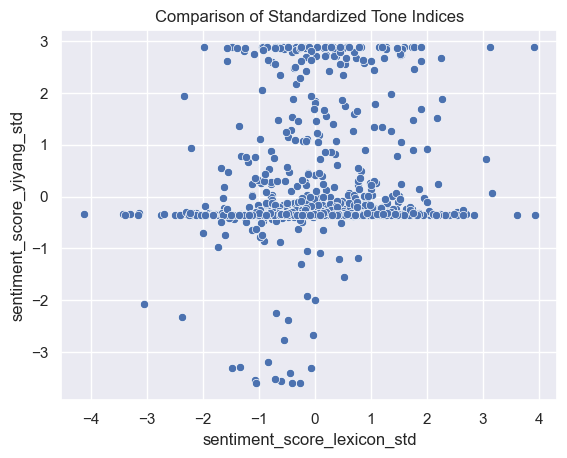

In [214]:
# Scatterplot for BoE dictionary and Finbert sentiment scores
sns.scatterplot(x='sentiment_score_lexicon_std', y='sentiment_score_yiyang_std', data=boe_speeches_sentiment)
plt.title('Comparison of Standardized Tone Indices')
plt.show()

In [215]:
# Correlation between custom dictionary and Finbert
from scipy.stats import pearsonr
corr, p_value = pearsonr(boe_speeches_sentiment['sentiment_score_custom_std'], boe_speeches_sentiment['sentiment_score_yiyang_std'])
print(f'Correlation: {corr:.2f}')

Correlation: 0.04


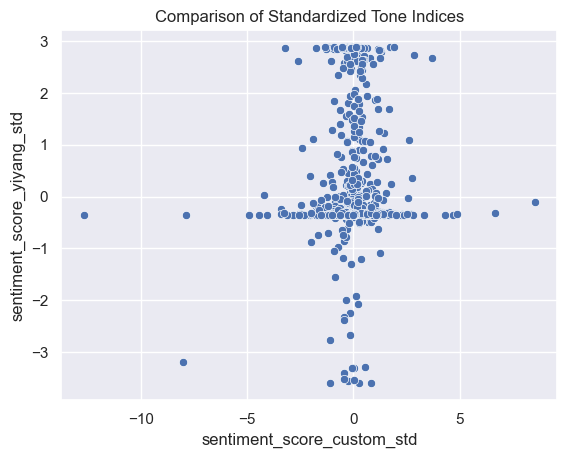

In [216]:
# Scatterplot for custom dictionary and Finbert sentiment scores
sns.scatterplot(x='sentiment_score_custom_std', y='sentiment_score_yiyang_std', data=boe_speeches_sentiment)
plt.title('Comparison of Standardized Tone Indices')
plt.show()

In [217]:
# Export the DataFrame to an Excel file
boe_speeches_sentiment.to_excel('boe_speeches_sentiment.xlsx', index=False)

print("DataFrame was exported successfully.")

DataFrame was exported successfully.


In [218]:
# Create a new column for agreement (1 for agree, 0 for disagree)
boe_speeches_sentiment['agreement_lexicon_yiyang'] = (boe_speeches_sentiment['lexicon_label'] == boe_speeches_sentiment['yiyang_label']).astype(int)

boe_speeches_sentiment.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ...                                text_lemmatised_str  \
4961    1998-09  1998  ...  thank chairman actually pleased opportunity re...   
4962    1998-10  1998  ...  great pleasure beautiful city bruges honour op...   
4963    1998-10  1998  ...  industry suffer volatility british economy pas...   
4964    1998-11  1998  ...  topic evening use forecast economic policy mak...   
4965    1998-11  1998  ...  six year ago week sterling leave exchange rate...   

     sentiment_score_lexicon_std  lexicon_label lexicon_label_percentile  \
4961                   -0.420532        Neutral                  Neutral   
4962                    0.815821        Neutral                 Positive   
4963                   -0.693424        Neutral                  Neutral   
4964                   -0.197920        Neutral                  Neutral   
4965                   -0.520744        Neutral                  Neutral   

     sentiment_score_custom_std  custom_label custom_label_percentile  \
4961                  -1.011042      Negative                Negative   
4962                  -0.259869       Neutral                 Neutral   
4963                  -0.136018       Neutral                 Neutral   
4964                  -0.395969       Neutral                Negative   
4965                  -1.453032      Negative                Negative   

     sentiment_score_yiyang_std  yiyang_label agreement_lexicon_yiyang  
4961                   1.291954      Positive                        0  
4962                  -0.260091       Neutral                        1  
4963                  -2.237069      Negative                        0  
4964                  -0.312321       Neutral                        1  
4965                  -0.356694       Neutral                        1  

[5 rows x 21 columns]

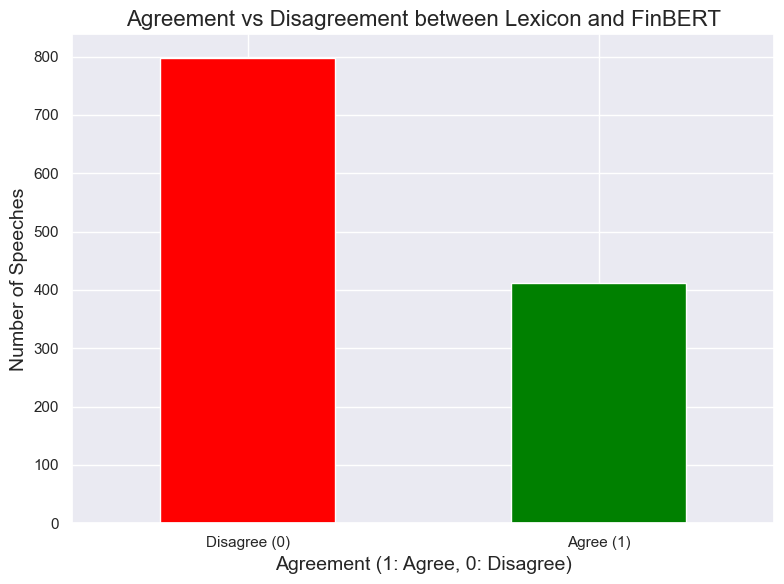

In [219]:
# Step 3: Visualize the agreement vs disagreement
agreement_count = boe_speeches_sentiment['agreement_lexicon_yiyang'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
agreement_count.plot(kind='bar', color=['red', 'green'])

# Adding labels and title
plt.title('Agreement vs Disagreement between Lexicon and FinBERT', fontsize=16)
plt.xlabel('Agreement (1: Agree, 0: Disagree)', fontsize=14)
plt.ylabel('Number of Speeches', fontsize=14)
plt.xticks([0, 1], ['Disagree (0)', 'Agree (1)'], rotation=0)
plt.tight_layout()

# Display the plot
plt.show()

In [220]:
# Create a new column for agreement (1 for agree, 0 for disagree)
boe_speeches_sentiment['agreement_custom_yiyang'] = (boe_speeches_sentiment['custom_label'] == boe_speeches_sentiment['yiyang_label']).astype(int)

boe_speeches_sentiment.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... sentiment_score_lexicon_std lexicon_label  \
4961    1998-09  1998  ...                   -0.420532       Neutral   
4962    1998-10  1998  ...                    0.815821       Neutral   
4963    1998-10  1998  ...                   -0.693424       Neutral   
4964    1998-11  1998  ...                   -0.197920       Neutral   
4965    1998-11  1998  ...                   -0.520744       Neutral   

      lexicon_label_percentile sentiment_score_custom_std custom_label  \
4961                   Neutral                  -1.011042     Negative   
4962                  Positive                  -0.259869      Neutral   
4963                   Neutral                  -0.136018      Neutral   
4964                   Neutral                  -0.395969      Neutral   
4965                   Neutral                  -1.453032     Negative   

      custom_label_percentile sentiment_score_yiyang_std yiyang_label  \
4961                 Negative                   1.291954     Positive   
4962                  Neutral                  -0.260091      Neutral   
4963                  Neutral                  -2.237069     Negative   
4964                 Negative                  -0.312321      Neutral   
4965                 Negative                  -0.356694      Neutral   

      agreement_lexicon_yiyang agreement_custom_yiyang  
4961                         0                       0  
4962                         1                       1  
4963                         0                       0  
4964                         1                       1  
4965                         1                       0  

[5 rows x 22 columns]

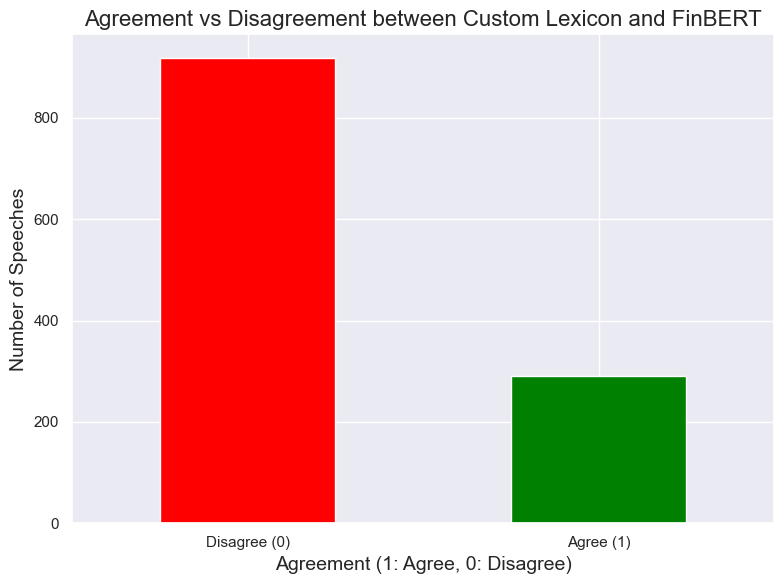

In [221]:
# Step 3: Visualize the agreement vs disagreement
agreement_count = boe_speeches_sentiment['agreement_custom_yiyang'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
agreement_count.plot(kind='bar', color=['red', 'green'])

# Adding labels and title
plt.title('Agreement vs Disagreement between Custom Lexicon and FinBERT', fontsize=16)
plt.xlabel('Agreement (1: Agree, 0: Disagree)', fontsize=14)
plt.ylabel('Number of Speeches', fontsize=14)
plt.xticks([0, 1], ['Disagree (0)', 'Agree (1)'], rotation=0)
plt.tight_layout()

# Display the plot
plt.show()

In [222]:
# Create a new column for agreement (1 for agree, 0 for disagree)
boe_speeches_sentiment_new['agreement_gpt_yiyang'] = (boe_speeches_sentiment_new['Gpt_sentiment'] == boe_speeches_sentiment_new['yiyang_label']).astype(int)

boe_speeches_sentiment_new.head()

reference         country       date  \
0  r980915a_BOE  united kingdom 1998-09-15   
1  r981021b_BOE  united kingdom 1998-10-21   
2  r981021a_BOE  united kingdom 1998-10-21   
3  r981101a_BOE  united kingdom 1998-11-01   
4  r981101b_BOE  united kingdom 1998-11-01   

                                               title   author  is_gov  \
0                                             Speech   george       1   
1                                  Britain in Europe   george       1   
2  Impact of the recent turbulence in internation...     king       1   
3        Economic policy, with and without forecasts     budd       0   
4  Inflation targeting in practice: the UK experi...  vickers       0   

                                                text date_format year_month  \
0  Thank you, Chairman. I'm actually very pleased...  1998-09-15    1998-09   
1  It's a great pleasure to be here in the beauti...  1998-10-21    1998-10   
2  Few industries have suffered more from volatil...  1998-10-21    1998-10   
3  My topic this evening is the use of forecasts ...  1998-11-01    1998-11   
4  Six years ago this week, sterling left the exc...  1998-11-01    1998-11   

   year  ... sentiment_score_lexicon_std lexicon_label  \
0  1998  ...                   -0.420532       Neutral   
1  1998  ...                    0.815821       Neutral   
2  1998  ...                   -0.693424       Neutral   
3  1998  ...                   -0.197920       Neutral   
4  1998  ...                   -0.520744       Neutral   

   lexicon_label_percentile sentiment_score_custom_std custom_label  \
0                   Neutral                  -1.011042     Negative   
1                  Positive                  -0.259869      Neutral   
2                   Neutral                  -0.136018      Neutral   
3                   Neutral                  -0.395969      Neutral   
4                   Neutral                  -1.453032     Negative   

   custom_label_percentile sentiment_score_yiyang_std yiyang_label  \
0                 Negative                   1.291954     Positive   
1                  Neutral                  -0.260091      Neutral   
2                  Neutral                  -2.237069     Negative   
3                 Negative                  -0.312321      Neutral   
4                 Negative                  -0.356694      Neutral   

   Gpt_sentiment agreement_gpt_yiyang  
0       Positive                    1  
1       Positive                    0  
2        Neutral                    0  
3        Neutral                    1  
4       Positive                    0  

[5 rows x 22 columns]

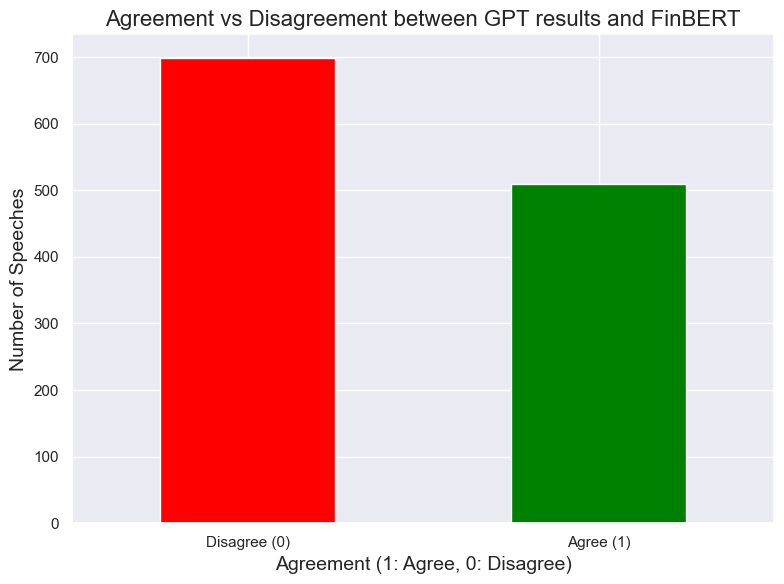

In [223]:
# Step 3: Visualize the agreement vs disagreement
agreement_count = boe_speeches_sentiment_new['agreement_gpt_yiyang'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
agreement_count.plot(kind='bar', color=['red', 'green'])

# Adding labels and title
plt.title('Agreement vs Disagreement between GPT results and FinBERT', fontsize=16)
plt.xlabel('Agreement (1: Agree, 0: Disagree)', fontsize=14)
plt.ylabel('Number of Speeches', fontsize=14)
plt.xticks([0, 1], ['Disagree (0)', 'Agree (1)'], rotation=0)
plt.tight_layout()

# Display the plot
plt.show()

**Accuracy Test**

In [225]:
# Randomly sample 5 reviews from the DataFrame.
accuracy_test = boe_speeches_sentiment.sample(n=5, random_state=101)

# Extract only the original review and summary columns.
accuracy_test = accuracy_test[['year_month','text', 'lexicon_label', 'yiyang_label']]

# Add columns for manually labelling the sentiment.
accuracy_test['sentiment_labelled'] = ''

# Display the sampled reviews.
accuracy_test

year_month                                               text  \
5431    2011-09  Thank you for the invitation to speak to you t...   
5592    2014-04  I delivered a speech entitled "The UK economy:...   
5479    2012-05  All speeches are available online at In the fi...   
5076    2002-01  It is a very great honour for me - as a gradua...   
5941    2019-04  John Maynard Keynes resigned as a delegate to ...   

     lexicon_label yiyang_label sentiment_labelled  
5431       Neutral      Neutral                     
5592       Neutral      Neutral                     
5479       Neutral      Neutral                     
5076      Positive      Neutral                     
5941      Positive      Neutral

In [226]:
# Extract a CSV file.
accuracy_test.to_csv('sentiment_accuracy_test.csv', index = True)

print("DataFrame was exported successfully.")

DataFrame was exported successfully.


In [ ]:
# Extract only the original review and summary columns.
accuracy_test = accuracy_test[['year_month','text', 'sentiment_lexicon_category', 'yiyang_label']]

accuracy_test

## 4. Display the data

### 4.1. Compare the sentiment scores

In [228]:
# Group and aggregate sentiment scores by month
sentiment_monthly = boe_speeches_sentiment.groupby('year_month')[['sentiment_score_yiyang_std','sentiment_score_lexicon_std', \
                                    'sentiment_score_custom_std']].mean().reset_index()
sentiment_monthly.head()

year_month  sentiment_score_yiyang_std  sentiment_score_lexicon_std  \
0    1998-09                    1.291954                    -0.420532   
1    1998-10                   -1.248580                     0.061198   
2    1998-11                   -0.341816                    -0.480369   
3    1998-12                   -0.356963                    -0.747103   
4    1999-01                   -0.601166                    -0.357277   

   sentiment_score_custom_std  
0                   -1.011042  
1                   -0.197944  
2                   -1.291942  
3                   -0.166944  
4                   -0.366383

In [229]:
sentiment_monthly['year_month_dt'] = sentiment_monthly['year_month'].dt.to_timestamp()

In [230]:
sentiment_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   year_month                   272 non-null    period[M]     
 1   sentiment_score_yiyang_std   272 non-null    float64       
 2   sentiment_score_lexicon_std  272 non-null    float64       
 3   sentiment_score_custom_std   272 non-null    float64       
 4   year_month_dt                272 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), period[M](1)
memory usage: 10.8 KB


In [231]:
import plotly.express as px
fig = px.line(
     sentiment_monthly,
     x='year_month_dt',
     y=['sentiment_score_yiyang_std','sentiment_score_lexicon_std', 'sentiment_score_custom_std'],
     title="Average monthly sentiment scores – Bank of England speeches (1997–2022)",
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

fig.show()

In [232]:
import plotly.express as px
fig = px.line(
     sentiment_monthly,
     x='year_month_dt',
     y=['sentiment_score_yiyang_std','sentiment_score_lexicon_std'],
     title="Average monthly sentiment scores – Bank of England speeches (1997–2022)",
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Show the figure
fig.show()

In [233]:
import plotly.express as px
fig = px.line(
     sentiment_monthly,
     x='year_month_dt',
     y=['sentiment_score_yiyang_std','sentiment_score_custom_std'],
     title="Average monthly sentiment scores – Bank of England speeches (1997–2022)",
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Show the figure
fig.show()

### 4.2. Finbert analysis

In [235]:
boe_speeches.columns

Index(['reference', 'country', 'date', 'title', 'author', 'is_gov', 'text',
       'date_format', 'year_month', 'year', 'text_cleaned', 'text_tokenised',
       'text_lemmatised', 'text_lemmatised_str', 'word_count', 'Negative',
       'Positive', 'Uncertainty', 'Litigious', 'Strong', 'Weak',
       'Constraining', 'sentiment_score_lexicon',
       'sentiment_score_lexicon_std', 'lexicon_label',
       'lexicon_label_percentile', 'negative_custom', 'positive_custom',
       'uncertainty_custom', 'sentiment_score_custom',
       'sentiment_score_custom_std', 'custom_label', 'custom_label_percentile',
       'yiyang_probs', 'yiyang_neutral', 'yiyang_positive', 'yiyang_negative',
       'yiyang_label', 'yiyang_confidence', 'sentiment_score_yiyang',
       'sentiment_score_yiyang_std'],
      dtype='object')

In [236]:
# Create a new DataFrame with all sentiment scores to include for comparison.
boe_speeches_finbert = boe_speeches[['reference', 'country', 'date', 'title', 'author', 'is_gov', 'text',
                                     'date_format', 'year_month', 'year', 'text_lemmatised', 'text_lemmatised_str',
                                     'yiyang_probs', 'yiyang_neutral', 'yiyang_positive', 'yiyang_negative',
                                     'yiyang_label', 'yiyang_confidence', 'sentiment_score_yiyang',
                                     'sentiment_score_yiyang_std']]

# View the DataFrame.
boe_speeches_finbert.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year                                    text_lemmatised  \
4961    1998-09  1998  [thank, chairman, actually, pleased, opportuni...   
4962    1998-10  1998  [great, pleasure, beautiful, city, bruges, hon...   
4963    1998-10  1998  [industry, suffer, volatility, british, econom...   
4964    1998-11  1998  [topic, evening, use, forecast, economic, poli...   
4965    1998-11  1998  [six, year, ago, week, sterling, leave, exchan...   

                                    text_lemmatised_str  \
4961  thank chairman actually pleased opportunity re...   
4962  great pleasure beautiful city bruges honour op...   
4963  industry suffer volatility british economy pas...   
4964  topic evening use forecast economic policy mak...   
4965  six year ago week sterling leave exchange rate...   

                                  yiyang_probs  yiyang_neutral  \
4961     [0.4900095, 0.5094528, 0.00053772976]        0.490009   
4962    [0.969261, 0.030696781, 4.2198746e-05]        0.969261   
4963      [0.37933072, 0.021060491, 0.5996088]        0.379331   
4964     [0.9847193, 0.0149205, 0.00036025542]        0.984719   
4965  [0.9990752, 0.0009056315, 1.9160354e-05]        0.999075   

      yiyang_positive  yiyang_negative yiyang_label  yiyang_confidence  \
4961         0.509453         0.000538     Positive           0.509453   
4962         0.030697         0.000042      Neutral           0.969261   
4963         0.021060         0.599609     Negative           0.599609   
4964         0.014921         0.000360      Neutral           0.984719   
4965         0.000906         0.000019      Neutral           0.999075   

      sentiment_score_yiyang  sentiment_score_yiyang_std  
4961                0.508915                    1.291954  
4962                0.030655                   -0.260091  
4963               -0.578548                   -2.237069  
4964                0.014560                   -0.312321  
4965                0.000886                   -0.356694

In [237]:
# Group and aggregate sentiment scores by month
finbert_monthly = boe_speeches_finbert.groupby('year_month')[['yiyang_neutral', 'yiyang_positive', 'yiyang_negative', \
                                                              'yiyang_confidence', 'sentiment_score_yiyang', \
                                                                 'sentiment_score_yiyang_std']].mean().reset_index()
finbert_monthly.head()

year_month  yiyang_neutral  yiyang_positive  yiyang_negative  \
0    1998-09        0.490009         0.509453         0.000538   
1    1998-10        0.674296         0.025879         0.299825   
2    1998-11        0.993288         0.006092         0.000620   
3    1998-12        0.999072         0.000866         0.000062   
4    1999-01        0.891927         0.016813         0.091260   

   yiyang_confidence  sentiment_score_yiyang  sentiment_score_yiyang_std  
0           0.509453                0.508915                    1.291954  
1           0.784435               -0.273947                   -1.248580  
2           0.993288                0.005471                   -0.341816  
3           0.999072                0.000804                   -0.356963  
4           0.891927               -0.074447                   -0.601166

In [238]:
# Extract a CSV file.
finbert_monthly.to_csv('boe_speeches_finbert_monthly.csv', index = True)

print("DataFrame was exported successfully.")

DataFrame was exported successfully.


In [239]:
# Change the date format
finbert_monthly['year_month_dt'] = finbert_monthly['year_month'].dt.to_timestamp()

In [240]:
# Plot the data over the full time period
fig = px.line(
     finbert_monthly,
     x='year_month_dt',
     y=['yiyang_neutral','yiyang_positive', 'yiyang_negative'],
     title="Average monthly sentiment scores – Bank of England speeches (1997–2022)",
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Show the figure
fig.show()

In [241]:
# Copy the DataFrame
seasonality_finbert = finbert_monthly.copy()

seasonality_finbert

year_month  yiyang_neutral  yiyang_positive  yiyang_negative  \
0      1998-09        0.490009         0.509453         0.000538   
1      1998-10        0.674296         0.025879         0.299825   
2      1998-11        0.993288         0.006092         0.000620   
3      1998-12        0.999072         0.000866         0.000062   
4      1999-01        0.891927         0.016813         0.091260   
..         ...             ...              ...              ...   
267    2022-05        0.765428         0.215132         0.019440   
268    2022-06        0.965101         0.034119         0.000780   
269    2022-07        0.971315         0.028482         0.000203   
270    2022-09        0.935309         0.062070         0.002621   
271    2022-10        0.987787         0.004736         0.007477   

     yiyang_confidence  sentiment_score_yiyang  sentiment_score_yiyang_std  \
0             0.509453                0.508915                    1.291954   
1             0.784435               -0.273947                   -1.248580   
2             0.993288                0.005471                   -0.341816   
3             0.999072                0.000804                   -0.356963   
4             0.891927               -0.074447                   -0.601166   
..                 ...                     ...                         ...   
267           0.908033                0.195692                    0.275485   
268           0.965101                0.033339                   -0.251380   
269           0.971315                0.028278                   -0.267802   
270           0.935309                0.059449                   -0.166647   
271           0.987787               -0.002741                   -0.368466   

    year_month_dt  
0      1998-09-01  
1      1998-10-01  
2      1998-11-01  
3      1998-12-01  
4      1999-01-01  
..            ...  
267    2022-05-01  
268    2022-06-01  
269    2022-07-01  
270    2022-09-01  
271    2022-10-01  

[272 rows x 8 columns]

In [242]:
# Filter the data by date for Covid
start_date = '2012-01'
end_date = '2022-12'

In [243]:
# Filter the data for specified period
seasonality_finbert_10 = seasonality_finbert[(seasonality_finbert['year_month'] >= start_date) & (seasonality_finbert['year_month'] <= end_date)]

In [244]:
# Set the datetime as index
seasonality_finbert_10.set_index('year_month_dt', inplace=True)

# View the DataFrame
seasonality_finbert_10

year_month  yiyang_neutral  yiyang_positive  yiyang_negative  \
year_month_dt                                                                
2012-01-01       2012-01        0.498525         0.501350         0.000125   
2012-02-01       2012-02        0.944208         0.049008         0.006784   
2012-03-01       2012-03        0.964541         0.030667         0.004791   
2012-04-01       2012-04        0.863628         0.135903         0.000468   
2012-05-01       2012-05        0.959425         0.039428         0.001147   
...                  ...             ...              ...              ...   
2022-05-01       2022-05        0.765428         0.215132         0.019440   
2022-06-01       2022-06        0.965101         0.034119         0.000780   
2022-07-01       2022-07        0.971315         0.028482         0.000203   
2022-09-01       2022-09        0.935309         0.062070         0.002621   
2022-10-01       2022-10        0.987787         0.004736         0.007477   

               yiyang_confidence  sentiment_score_yiyang  \
year_month_dt                                              
2012-01-01              0.997744                0.501224   
2012-02-01              0.944208                0.042224   
2012-03-01              0.964541                0.025876   
2012-04-01              0.863628                0.135435   
2012-05-01              0.959425                0.038281   
...                          ...                     ...   
2022-05-01              0.908033                0.195692   
2022-06-01              0.965101                0.033339   
2022-07-01              0.971315                0.028278   
2022-09-01              0.935309                0.059449   
2022-10-01              0.987787               -0.002741   

               sentiment_score_yiyang_std  
year_month_dt                              
2012-01-01                       1.266996  
2012-02-01                      -0.222546  
2012-03-01                      -0.275599  
2012-04-01                       0.079940  
2012-05-01                      -0.235342  
...                                   ...  
2022-05-01                       0.275485  
2022-06-01                      -0.251380  
2022-07-01                      -0.267802  
2022-09-01                      -0.166647  
2022-10-01                      -0.368466  

[125 rows x 7 columns]

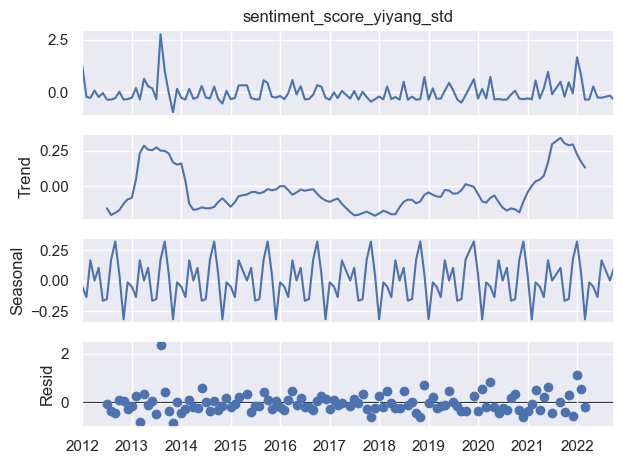

In [245]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform decomposition
decomposed = seasonal_decompose(seasonality_finbert_10['sentiment_score_yiyang_std'], model='additive', period=12)

# Plot the decomposition
decomposed.plot()
plt.show()

**Observations Peaks**
- August 2013: Peak with a speech announcing Jane Austen on 10 GBP note and a discussion of the evolution of monetary policy since 2008-2009 crisis
- January 2022: speech about inflation with a sense of urgency about controlling inflation with reassurance that the Bank is actively monitoring and prepared to act responsibly. 

## Governor speeches only

In [248]:
# Filter speeches for governors only
boe_speeches_finbert_gov = boe_speeches_finbert[boe_speeches_finbert['is_gov'] == 1]

# View the DataFrame
boe_speeches_finbert_gov.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4966  r981119a_BOE  united kingdom 1998-11-19   
4969  r990112a_BOE  united kingdom 1999-01-12   

                                                  title  author  is_gov  \
4961                                             Speech  george       1   
4962                                  Britain in Europe  george       1   
4963  Impact of the recent turbulence in internation...    king       1   
4966                                             Speech  george       1   
4969                                             Speech  george       1   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4966  Let me put some of the recent newspaper headli...  1998-11-19   
4969  I am only too well aware of the pressure curre...  1999-01-12   

     year_month  year                                    text_lemmatised  \
4961    1998-09  1998  [thank, chairman, actually, pleased, opportuni...   
4962    1998-10  1998  [great, pleasure, beautiful, city, bruges, hon...   
4963    1998-10  1998  [industry, suffer, volatility, british, econom...   
4966    1998-11  1998  [let, put, recent, newspaper, headline, alongs...   
4969    1999-01  1999  [well, aware, pressure, currently, face, large...   

                                    text_lemmatised_str  \
4961  thank chairman actually pleased opportunity re...   
4962  great pleasure beautiful city bruges honour op...   
4963  industry suffer volatility british economy pas...   
4966  let put recent newspaper headline alongside fa...   
4969  well aware pressure currently face large part ...   

                                 yiyang_probs  yiyang_neutral  \
4961    [0.4900095, 0.5094528, 0.00053772976]        0.490009   
4962   [0.969261, 0.030696781, 4.2198746e-05]        0.969261   
4963     [0.37933072, 0.021060491, 0.5996088]        0.379331   
4966  [0.99606884, 0.002449211, 0.0014819275]        0.996069   
4969     [0.78577423, 0.031724565, 0.1825012]        0.785774   

      yiyang_positive  yiyang_negative yiyang_label  yiyang_confidence  \
4961         0.509453         0.000538     Positive           0.509453   
4962         0.030697         0.000042      Neutral           0.969261   
4963         0.021060         0.599609     Negative           0.599609   
4966         0.002449         0.001482      Neutral           0.996069   
4969         0.031725         0.182501      Neutral           0.785774   

      sentiment_score_yiyang  sentiment_score_yiyang_std  
4961                0.508915                    1.291954  
4962                0.030655                   -0.260091  
4963               -0.578548                   -2.237069  
4966                0.000967                   -0.356432  
4969               -0.150777                   -0.848870

In [249]:
# Review the DataFrame
boe_speeches_finbert_gov.info()

<class 'pandas.core.frame.DataFrame'>
Index: 245 entries, 4961 to 6167
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   reference                   245 non-null    object        
 1   country                     245 non-null    object        
 2   date                        245 non-null    datetime64[ns]
 3   title                       245 non-null    object        
 4   author                      245 non-null    object        
 5   is_gov                      245 non-null    int64         
 6   text                        245 non-null    object        
 7   date_format                 245 non-null    datetime64[ns]
 8   year_month                  245 non-null    period[M]     
 9   year                        245 non-null    int32         
 10  text_lemmatised             245 non-null    object        
 11  text_lemmatised_str         245 non-null    object        


In [250]:
# Group and aggregate sentiment scores by month
finbert_monthly_gov = boe_speeches_finbert_gov.groupby('year_month')[['yiyang_neutral', 'yiyang_positive', 'yiyang_negative', \
                                                              'yiyang_confidence', 'sentiment_score_yiyang', \
                                                                 'sentiment_score_yiyang_std']].mean().reset_index()
finbert_monthly_gov.head()

year_month  yiyang_neutral  yiyang_positive  yiyang_negative  \
0    1998-09        0.490009         0.509453         0.000538   
1    1998-10        0.674296         0.025879         0.299825   
2    1998-11        0.996069         0.002449         0.001482   
3    1999-01        0.891927         0.016813         0.091260   
4    1999-02        0.971069         0.028773         0.000158   

   yiyang_confidence  sentiment_score_yiyang  sentiment_score_yiyang_std  
0           0.509453                0.508915                    1.291954  
1           0.784435               -0.273947                   -1.248580  
2           0.996069                0.000967                   -0.356432  
3           0.891927               -0.074447                   -0.601166  
4           0.971069                0.028615                   -0.266709

In [251]:
# Change the date format
finbert_monthly_gov['year_month_dt'] = finbert_monthly_gov['year_month'].dt.to_timestamp()

In [252]:
# Filter the data for 10 years
start_date = '2012-01'
end_date = '2022-12'

In [253]:
# Filter the data for specified period
seasonality_finbert_gov_10 = finbert_monthly_gov[(finbert_monthly_gov['year_month'] >= start_date) & \
                          (finbert_monthly_gov['year_month'] <= end_date)]

In [254]:
# Set the datetime as index
seasonality_finbert_gov_10.set_index('year_month_dt', inplace=True)

# View the DataFrame
seasonality_finbert_gov_10

year_month  yiyang_neutral  yiyang_positive  yiyang_negative  \
year_month_dt                                                                
2012-01-01       2012-01        0.000102         0.999860         0.000039   
2012-03-01       2012-03        0.999775         0.000209         0.000016   
2012-05-01       2012-05        0.990324         0.006584         0.003092   
2012-10-01       2012-10        0.993951         0.006027         0.000023   
2012-11-01       2012-11        0.996141         0.003737         0.000122   
...                  ...             ...              ...              ...   
2021-11-01       2021-11        0.978894         0.020708         0.000398   
2022-02-01       2022-02        0.066833         0.932992         0.000175   
2022-05-01       2022-05        0.860221         0.011863         0.127916   
2022-07-01       2022-07        0.993815         0.005688         0.000497   
2022-10-01       2022-10        0.951426         0.005657         0.042917   

               yiyang_confidence  sentiment_score_yiyang  \
year_month_dt                                              
2012-01-01              0.999860                0.999821   
2012-03-01              0.999775                0.000193   
2012-05-01              0.990324                0.003491   
2012-10-01              0.993951                0.006004   
2012-11-01              0.996141                0.003615   
...                          ...                     ...   
2021-11-01              0.978894                0.020310   
2022-02-01              0.932992                0.932817   
2022-05-01              0.860221               -0.116053   
2022-07-01              0.993815                0.005191   
2022-10-01              0.951426               -0.037260   

               sentiment_score_yiyang_std  
year_month_dt                              
2012-01-01                       2.885036  
2012-03-01                      -0.358946  
2012-05-01                      -0.348241  
2012-10-01                      -0.340087  
2012-11-01                      -0.347839  
...                                   ...  
2021-11-01                      -0.293662  
2022-02-01                       2.667595  
2022-05-01                      -0.736185  
2022-07-01                      -0.342724  
2022-10-01                      -0.480488  

[85 rows x 7 columns]

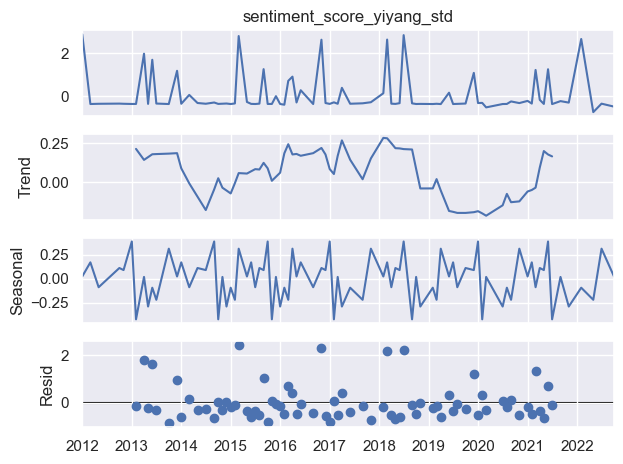

In [255]:
# Perform decomposition
decomposed = seasonal_decompose(seasonality_finbert_gov_10['sentiment_score_yiyang_std'], model='additive', period=12)

# Plot the decomposition
decomposed.plot()
plt.show()

### 4.1. Covid

In [257]:
# Filter the data by date for Covid
start_date = '2020-01'
end_date = '2022-12'

In [258]:
# Filter the data for specified period
finbert_covid = finbert_monthly[(finbert_monthly['year_month_dt'] >= start_date) & (finbert_monthly['year_month_dt'] <= end_date)]

In [259]:
fig = px.line(
     finbert_covid,
     x='year_month_dt',
     y=['yiyang_neutral','yiyang_positive', 'yiyang_negative'],
     title='Average monthly Finbert scores – Bank of England speeches during Covid (2020–2022)',
     labels={'value': 'Average score', 'variable': 'Metric'},
    color_discrete_sequence=['blue', 'green', 'red']
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Show the figure
fig.show()

In [260]:
fig = px.line(
     finbert_covid,
     x='year_month_dt',
     y=['sentiment_score_yiyang_std'],
     title='Average monthly standardised Finbert scores – Bank of England speeches during Covid (2020–2022)',
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Show the figure
fig.show()

In [261]:
# Filter the data for specified period
finbert_gov_covid = finbert_monthly_gov[(finbert_monthly_gov['year_month_dt'] >= start_date) & (finbert_monthly_gov['year_month_dt'] <= end_date)]

In [262]:
fig = px.line(
     finbert_gov_covid,
     x='year_month_dt',
     y=['yiyang_neutral','yiyang_positive', 'yiyang_negative'],
     title='Average monthly Finbert scores – Bank of England speeches during Covid (2020–2022)',
     labels={'value': 'Average score', 'variable': 'Metric'},
    color_discrete_sequence=['blue', 'green', 'red']
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Show the figure
fig.show()

### 4.2. Brexit vote

In [264]:
# Filter the data by date for before and after Brexit
start_date = '2016-01'
end_date = '2017-06'

In [265]:
# Filter the data for specified period
finbert_brexit = finbert_monthly[(finbert_monthly['year_month_dt'] >= start_date) & (finbert_monthly['year_month_dt'] <= end_date)]

In [266]:
fig = px.line(
     finbert_brexit,
     x='year_month_dt',
     y=['yiyang_neutral','yiyang_positive', 'yiyang_negative'],
     title='Average monthly Finbert scores – Bank of England speeches during Brexit (2016–2017)',
     labels={'value': 'Average score', 'variable': 'Metric'},
    color_discrete_sequence=['blue', 'green', 'red']
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Show the figure
fig.show()

In [267]:
fig = px.line(
     finbert_covid,
     x='year_month_dt',
     y=['sentiment_score_yiyang_std'],
     title='Average monthly stamdardised Finbert scores – Bank of England speeches during Brexit (2016–2017)',
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Show the figure
fig.show()

### Filter the dataframe

In [269]:
target_words = {
    'inflation': ['inflation'],           
    'monetary policy': ['monetary policy'],               
    'price stability': ['price stability'],
    'exchange rate': ['exchange rate'],
    'growth': ['growth'],
    'financial market': ['finanical market']
}

In [270]:
def count_word(text, word):
    tokens = [w.lower() for w in word_tokenize(str(text))]
    return tokens.count(word.lower())

# Assuming your DataFrame is 'df' and text column is 'speech_text'

for category, words in target_words.items():
    # Since each category only has one word, no need to iterate over list, just take the first
    word = words[0]
    # Count occurrences of the word in each speech
    boe_speeches_sentiment[category + '_count'] = boe_speeches_sentiment['text_lemmatised'].apply(lambda x: count_word(x, word))

# Now, create separate dataframes per category
inflation_df = boe_speeches_sentiment[['text_lemmatised', 'inflation_count']].copy()
monetary_policy_df = boe_speeches_sentiment[['text_lemmatised', 'monetary policy_count']].copy()
price_stability_df = boe_speeches_sentiment[['text_lemmatised', 'price stability_count']].copy()
exchange_rate_df = boe_speeches_sentiment[['text_lemmatised', 'exchange rate_count']].copy()
growth_df = boe_speeches_sentiment[['text_lemmatised', 'growth_count']].copy()
financial_market_df = boe_speeches_sentiment[['text_lemmatised', 'financial market_count']].copy()

# (Optional) filter for speeches where the target word appears at least once
inflation_df = inflation_df[inflation_df['inflation_count'] > 3]
monetary_policy_df = monetary_policy_df[monetary_policy_df['monetary policy_count'] > 3]
price_stability_df = price_stability_df[price_stability_df['price stability_count'] > 3]
exchange_rate_df = exchange_rate_df[exchange_rate_df['exchange rate_count'] > 3]
growth_df = growth_df[growth_df['growth_count'] > 3]
financial_market_df = financial_market_df[financial_market_df['financial market_count'] > 3]

In [271]:
def count_word(text, word):
    tokens = [w.lower() for w in word_tokenize(str(text))]
    return tokens.count(word.lower())

# Assuming your DataFrame is 'df' and text column is 'speech_text'

for category, words in target_words.items():
    # Since each category only has one word, no need to iterate over list, just take the first
    word = words[0]
    # Count occurrences of the word in each speech
    boe_speeches_sentiment[category + '_count'] = boe_speeches_sentiment['text'].apply(lambda x: count_word(x, word))

# Now, create separate dataframes per category
inflation_df = boe_speeches_sentiment[['text', 'inflation_count']].copy()
monetary_policy_df = boe_speeches_sentiment[['text', 'monetary policy_count']].copy()
price_stability_df = boe_speeches_sentiment[['text', 'price stability_count']].copy()
exchange_rate_df = boe_speeches_sentiment[['text', 'exchange rate_count']].copy()
growth_df = boe_speeches_sentiment[['text', 'growth_count']].copy()
financial_market_df = boe_speeches_sentiment[['text', 'financial market_count']].copy()

# (Optional) filter for speeches where the target word appears at least once
inflation_df = inflation_df[inflation_df['inflation_count'] > 3]
monetary_policy_df = monetary_policy_df[monetary_policy_df['monetary policy_count'] > 3]
price_stability_df = price_stability_df[price_stability_df['price stability_count'] > 3]
exchange_rate_df = exchange_rate_df[exchange_rate_df['exchange rate_count'] > 3]
growth_df = growth_df[growth_df['growth_count'] > 3]
financial_market_df = financial_market_df[financial_market_df['financial market_count'] > 3]

In [272]:
inflation_df.head()

text  inflation_count
4961  Thank you, Chairman. I'm actually very pleased...               22
4963  Few industries have suffered more from volatil...               11
4964  My topic this evening is the use of forecasts ...               46
4965  Six years ago this week, sterling left the exc...               92
4966  Let me put some of the recent newspaper headli...               11

In [273]:
monetary_policy_df.head()

Empty DataFrame
Columns: [text, monetary policy_count]
Index: []

In [274]:
price_stability_df.head()

Empty DataFrame
Columns: [text, price stability_count]
Index: []

In [275]:
exchange_rate_df.head()

Empty DataFrame
Columns: [text, exchange rate_count]
Index: []

In [276]:
growth_df.head()

text  growth_count
4961  Thank you, Chairman. I'm actually very pleased...            15
4962  It's a great pleasure to be here in the beauti...             8
4963  Few industries have suffered more from volatil...            18
4965  Six years ago this week, sterling left the exc...             8
4966  Let me put some of the recent newspaper headli...            19

In [277]:
financial_market_df.head()

Empty DataFrame
Columns: [text, financial market_count]
Index: []

In [278]:
def count_target_words(text, target_words):
    tokens = [w.lower() for w in word_tokenize(str(text))]
    count = sum(tokens.count(word) for word in target_words)
    return count

# Apply and add as a new column
target_words = ['inflation', 'monetary policy', 'price stability', 'exchange rate', 'growth', 'financial market']
boe_speeches_sentiment['target_word_freq'] = boe_speeches_sentiment['text_lemmatised_str'].apply(lambda x: count_target_words(x, target_words))

# View the dataFrame
boe_speeches_sentiment.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... yiyang_label agreement_lexicon_yiyang  \
4961    1998-09  1998  ...     Positive                        0   
4962    1998-10  1998  ...      Neutral                        1   
4963    1998-10  1998  ...     Negative                        0   
4964    1998-11  1998  ...      Neutral                        1   
4965    1998-11  1998  ...      Neutral                        1   

      agreement_custom_yiyang inflation_count monetary policy_count  \
4961                        0              22                     0   
4962                        1               2                     0   
4963                        0              11                     0   
4964                        1              46                     0   
4965                        0              92                     0   

      price stability_count exchange rate_count growth_count  \
4961                      0                   0           15   
4962                      0                   0            8   
4963                      0                   0           18   
4964                      0                   0            2   
4965                      0                   0            8   

      financial market_count target_word_freq  
4961                       0               37  
4962                       0               10  
4963                       0               29  
4964                       0               48  
4965                       0              101  

[5 rows x 29 columns]

In [279]:
# For example, speeches where 'inflation' appears more than 3 times
inflation_df = boe_speeches_sentiment[boe_speeches_sentiment['target_word_freq'] > 5]

inflation_df.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... yiyang_label agreement_lexicon_yiyang  \
4961    1998-09  1998  ...     Positive                        0   
4962    1998-10  1998  ...      Neutral                        1   
4963    1998-10  1998  ...     Negative                        0   
4964    1998-11  1998  ...      Neutral                        1   
4965    1998-11  1998  ...      Neutral                        1   

      agreement_custom_yiyang inflation_count monetary policy_count  \
4961                        0              22                     0   
4962                        1               2                     0   
4963                        0              11                     0   
4964                        1              46                     0   
4965                        0              92                     0   

      price stability_count exchange rate_count growth_count  \
4961                      0                   0           15   
4962                      0                   0            8   
4963                      0                   0           18   
4964                      0                   0            2   
4965                      0                   0            8   

      financial market_count target_word_freq  
4961                       0               37  
4962                       0               10  
4963                       0               29  
4964                       0               48  
4965                       0              101  

[5 rows x 29 columns]

## 4. Exploratory Analysis for Correlation with Economic Indicators

### 4.1. Prepare the data

In [282]:
# List of DataFrames to merge
dataframes_to_merge = [unemployment_uk, exchange_rates_uk, inflation_uk, credit_growth_uk, bank_rates_uk, gdp_uk, confidence_uk]

# Use reduce to merge all DataFrames in the list
boe_speeches_indicators = reduce(lambda left, right: left.merge(right, on='year_month', how='left'), dataframes_to_merge, boe_speeches)

# View the merged DataFrame
boe_speeches_indicators.head()

reference         country       date  \
0  r980915a_BOE  united kingdom 1998-09-15   
1  r981021b_BOE  united kingdom 1998-10-21   
2  r981021a_BOE  united kingdom 1998-10-21   
3  r981101a_BOE  united kingdom 1998-11-01   
4  r981101b_BOE  united kingdom 1998-11-01   

                                               title   author  is_gov  \
0                                             Speech   george       1   
1                                  Britain in Europe   george       1   
2  Impact of the recent turbulence in internation...     king       1   
3        Economic policy, with and without forecasts     budd       0   
4  Inflation targeting in practice: the UK experi...  vickers       0   

                                                text date_format year_month  \
0  Thank you, Chairman. I'm actually very pleased...  1998-09-15    1998-09   
1  It's a great pleasure to be here in the beauti...  1998-10-21    1998-10   
2  Few industries have suffered more from volatil...  1998-10-21    1998-10   
3  My topic this evening is the use of forecasts ...  1998-11-01    1998-11   
4  Six years ago this week, sterling left the exc...  1998-11-01    1998-11   

   year  ... 12-Month Growth of UK Consumer Credit (excl SLC, %)  \
0  1998  ...                                               17.6    
1  1998  ...                                               17.7    
2  1998  ...                                               17.7    
3  1998  ...                                               17.4    
4  1998  ...                                               17.4    

  12-Month Growth of UK Consumer Credit (excl SLC & CC, %)  \
0                                               15.3         
1                                               15.6         
2                                               15.6         
3                                               14.9         
4                                               14.9         

  12-Month Growth of Sterling Credit Cards to Individuals (%) Bank Rate  \
0                                               26.7             0.0750   
1                                               25.8             0.0725   
2                                               25.8             0.0725   
3                                               26.9             0.0675   
4                                               26.9             0.0675   

   Gross Value Added  Manufacturing  Service Industries  \
0                0.0            0.3                -0.1   
1                0.4            0.2                 0.4   
2                0.4            0.2                 0.4   
3                0.4           -0.1                 0.4   
4                0.4           -0.1                 0.4   

   Information & Communication  Financial & Insurance Activities  \
0                         -0.1                              -2.4   
1                          4.5                              -2.7   
2                          4.5                              -2.7   
3                          2.0                              -1.9   
4                          2.0                              -1.9   

   confidence_index  
0              -4.9  
1              -6.7  
2              -6.7  
3              -3.5  
4              -3.5  

[5 rows x 57 columns]

In [283]:
# Check for missing values.
boe_speeches_indicators.isnull().sum()

reference                                                      0
country                                                        0
date                                                           0
title                                                          0
author                                                         0
is_gov                                                         0
text                                                           0
date_format                                                    0
year_month                                                     0
year                                                           0
text_cleaned                                                   0
text_tokenised                                                 0
text_lemmatised                                                0
text_lemmatised_str                                            0
word_count                                                     0
Negative                 

In [284]:
# Explore the DataFrame.
boe_speeches_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209 entries, 0 to 1208
Data columns (total 57 columns):
 #   Column                                                       Non-Null Count  Dtype         
---  ------                                                       --------------  -----         
 0   reference                                                    1209 non-null   object        
 1   country                                                      1209 non-null   object        
 2   date                                                         1209 non-null   datetime64[ns]
 3   title                                                        1209 non-null   object        
 4   author                                                       1209 non-null   object        
 5   is_gov                                                       1209 non-null   int64         
 6   text                                                         1209 non-null   object        
 7   date_format    

### 4.2. Plot the data

In [286]:
# Display all column names.
boe_speeches_indicators.columns

Index(['reference', 'country', 'date', 'title', 'author', 'is_gov', 'text',
       'date_format', 'year_month', 'year', 'text_cleaned', 'text_tokenised',
       'text_lemmatised', 'text_lemmatised_str', 'word_count', 'Negative',
       'Positive', 'Uncertainty', 'Litigious', 'Strong', 'Weak',
       'Constraining', 'sentiment_score_lexicon',
       'sentiment_score_lexicon_std', 'lexicon_label',
       'lexicon_label_percentile', 'negative_custom', 'positive_custom',
       'uncertainty_custom', 'sentiment_score_custom',
       'sentiment_score_custom_std', 'custom_label', 'custom_label_percentile',
       'yiyang_probs', 'yiyang_neutral', 'yiyang_positive', 'yiyang_negative',
       'yiyang_label', 'yiyang_confidence', 'sentiment_score_yiyang',
       'sentiment_score_yiyang_std', 'Unemployment rate',
       'Sterling (Jan 2005 = 100)', 'USD into Sterling',
       'Japanese Yen into Sterling', 'Euro into Sterling', 'Inflation Rate',
       '12-Month Growth of UK Consumer Credit (excl 

In [287]:
boe_speeches_indicators['year_month'].dtypes

period[M]

In [288]:
# Convert 'year_month' Period to datetime
boe_speeches_indicators['date'] = boe_speeches_indicators['year_month'].dt.to_timestamp()

In [289]:
boe_speeches_indicators['year_month'].dtypes

period[M]

**Confidence Index**

KeyError: 'text_compound'

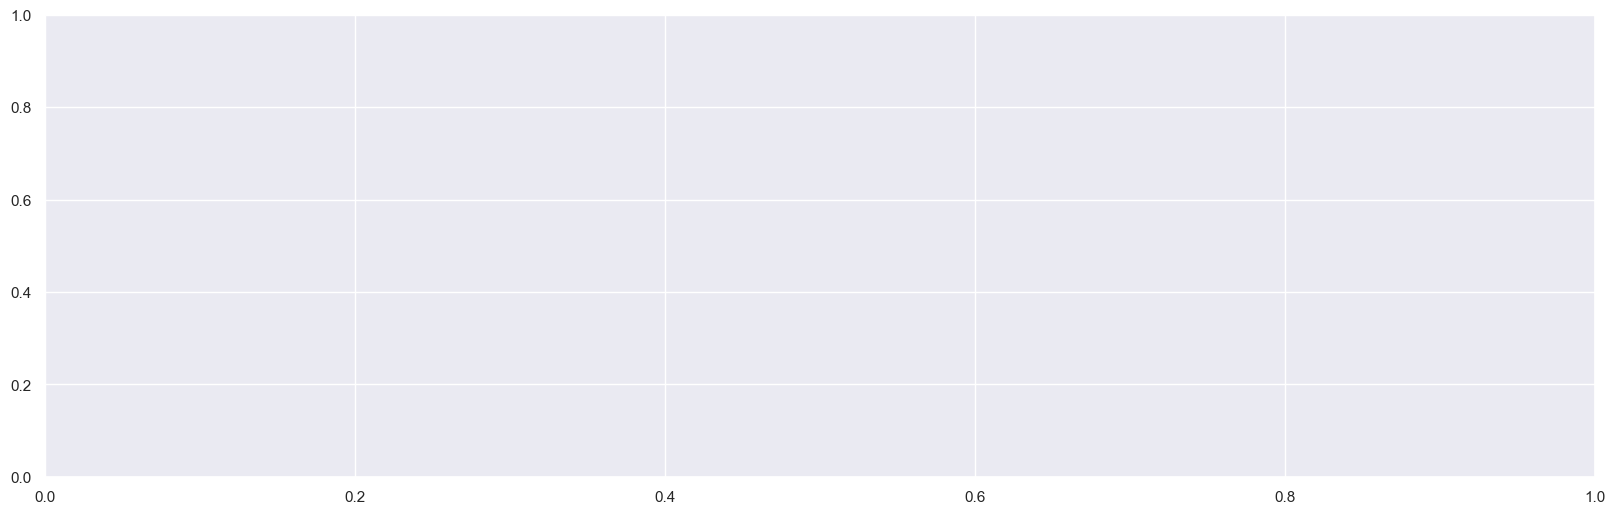

In [291]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators['text_compound'], color='blue', label='VADER compound score')
ax1.set_xlabel('Date')
ax1.set_ylabel('VADER compound score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['confidence_index'], color='red', label='Confidence Index')
ax2.set_ylabel('Confidence Index', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England VADER Sentiment Score vs UK Confidence Index')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators['sentiment_score_lm_weighted'], color='blue', label='sentiment_score_lm_weighted')
ax1.set_xlabel('Date')
ax1.set_ylabel('sentiment_score_lm_weighted', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['confidence_index'], color='red', label='Confidence Index')
ax2.set_ylabel('Confidence Index', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England Loughran-McDonald Weighted Sentiment Score vs UK Confidence Index')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators[['text_pos', 'text_neg', 'text_neu']], color='blue', label='VADER compound score')
ax1.set_xlabel('Date')
ax1.set_ylabel('VADER Scores', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['confidence_index'], color='red', label='Confidence Index')
ax2.set_ylabel('Confidence Index', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England VADER Sentiment Score vs UK Confidence Index')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators[['Positive', 'Negative', 'Uncertainty']], color='blue', label='Lexicom Sentiment')
ax1.set_xlabel('Date')
ax1.set_ylabel('Lexicon Sentiment', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['confidence_index'], color='red', label='Confidence Index')
ax2.set_ylabel('Confidence Index', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England VADER Sentiment Score vs UK Confidence Index')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

**Inflation**

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators[['negative_lm', 'positive_lm', 'uncertainty_lm']], color='blue', label='weighted_sentiment_LM')
ax1.set_xlabel('Date')
ax1.set_ylabel('weighted_sentiment_LM', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['Inflation Rate'], color='red', label='Inflation Rate')
ax2.set_ylabel('Inflation Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England Loughran-McDonald Weighted Sentiment Score vs UK Inflation Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators['sentiment_score_lm_weighted'], color='blue', label='sentiment_score_lm_weighted')
ax1.set_xlabel('Date')
ax1.set_ylabel('weighted_sentiment_LM', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['Unemployment rate'], color='red', label='Unemployment Rate')
ax2.set_ylabel('Unemployment Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England Loughran-McDonald Weighted Sentiment Score vs UK Unemployment Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

**Interest Rates**

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators['sentiment_score_lm_weighted'], color='blue', label='sentiment_score_lm_weighted')
ax1.set_xlabel('Date')
ax1.set_ylabel('weighted_sentiment_LM', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['Bank Rate'], color='red', label='Bank Rate')
ax2.set_ylabel('Bank Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England Loughran-McDonald Weighted Sentiment Score vs UK Bank Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators['sentiment_score_lm_weighted'], color='blue', label='sentiment_score_lm_weighted')
ax1.set_xlabel('Date')
ax1.set_ylabel('weighted_sentiment_LM', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['Bank Rate'], color='red', label='Bank Rate')
ax2.set_ylabel('Bank Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England Loughran-McDonald Weighted Sentiment Score vs UK Bank Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators[['text_pos', 'text_neg', 'text_neu']], color='blue', label='VADER compound score')
ax1.set_xlabel('Date')
ax1.set_ylabel('VADER Scores', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['Bank Rate'], color='red', label='Bank Rate')
ax2.set_ylabel('Bank Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England VADER Sentiment Score vs UK Bank Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

### 4.3. Initial statistical analysis

In [ ]:
# Create a pairplot for sentiment score, unemployment, inflation and exchange rates.
columns_sentiment_lexicon = ['sentiment_score_lexicon_weighted', 'Unemployment rate', 'Inflation Rate', 'USD into Sterling', \
                             'Japanese Yen into Sterling', 'Euro into Sterling', 'Bank Rate', \
                             '12-Month Growth of UK Consumer Credit (excl SLC, %)', \
                             '12-Month Growth of UK Consumer Credit (excl SLC & CC, %)', \
                             '12-Month Growth of Sterling Credit Cards to Individuals (%)', 'Gross Value Added', \
                             'Manufacturing', 'Service Industries', 'Information & Communication', \
                             'Financial & Insurance Activities', 'confidence_index']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_sentiment_lexicon], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout()
plt.show()

In [ ]:
# Create the correlation matrix for the sentiment score with the indicators only.
correlation_matrix_lexicon = boe_speeches_indicators[columns_sentiment_lexicon].corr()

# Display the correlation matrix
correlation_matrix_lexicon

In [ ]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_lexicon, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Economic Indicators')
plt.show()

In [ ]:
# Create a pairplot for weighted sentiment score, unemployment, inflation and exchange rates.
columns_sentiment_lm = ['sentiment_score_lm_weighted', 'Unemployment rate', 'Inflation Rate', 'USD into Sterling', \
                             'Japanese Yen into Sterling', 'Euro into Sterling', 'Bank Rate', \
                             '12-Month Growth of UK Consumer Credit (excl SLC, %)', \
                             '12-Month Growth of UK Consumer Credit (excl SLC & CC, %)', \
                             '12-Month Growth of Sterling Credit Cards to Individuals (%)', 'Gross Value Added', \
                             'Manufacturing', 'Service Industries', 'Information & Communication', \
                             'Financial & Insurance Activities', 'confidence_index']

In [ ]:
# Create the correlation matrix for the sentiment score with the indicators only.
correlation_matrix_lm = boe_speeches_indicators[columns_sentiment_lm].corr()

# Display the correlation matrix
correlation_matrix_lm

In [ ]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_lm, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Economic Indicators')
plt.show()

In [ ]:
# Create a pairplot for sentiment score, unemployment, inflation and exchange rates.
columns_vader_compound = ['text_compound', 'Unemployment rate', 'Inflation Rate', 'USD into Sterling', \
                             'Japanese Yen into Sterling', 'Euro into Sterling', 'Bank Rate', \
                             '12-Month Growth of UK Consumer Credit (excl SLC, %)', \
                             '12-Month Growth of UK Consumer Credit (excl SLC & CC, %)', \
                             '12-Month Growth of Sterling Credit Cards to Individuals (%)', 'Gross Value Added', \
                             'Manufacturing', 'Service Industries', 'Information & Communication', \
                             'Financial & Insurance Activities', 'confidence_index']

In [ ]:
# Create the correlation matrix for the sentiment score with the indicators only.
correlation_matrix_vader = boe_speeches_indicators[columns_vader_compound].corr()

# Display the correlation matrix
correlation_matrix_vader

In [ ]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_vader, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Economic Indicators')
plt.show()

In [ ]:
# Create a pairplot for sentiment score, unemployment, inflation and exchange rates.
columns_vader_all = ['text_compound', 'text_neg', 'text_neu', 'text_pos', 'Unemployment rate', 'Inflation Rate', \
                     'USD into Sterling', 'Japanese Yen into Sterling', 'Euro into Sterling', 'Bank Rate', \
                     '12-Month Growth of UK Consumer Credit (excl SLC, %)', \
                     '12-Month Growth of UK Consumer Credit (excl SLC & CC, %)', \
                     '12-Month Growth of Sterling Credit Cards to Individuals (%)', 'Gross Value Added', \
                     'Manufacturing', 'Service Industries', 'Information & Communication', \
                     'Financial & Insurance Activities', 'confidence_index']

In [ ]:
# Create the correlation matrix for the sentiment score with the indicators only.
correlation_matrix_vader_all = boe_speeches_indicators[columns_vader_all].corr()

# Display the correlation matrix
correlation_matrix_vader_all

In [ ]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_vader_all, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Economic Indicators')
plt.show()

In [ ]:
# Create a pairplot for sentiment score, unemployment, inflation and exchange rates.
columns_yiyang = ['yiyang_confidence', 'Unemployment rate', 'Inflation Rate', 'USD into Sterling', \
                             'Japanese Yen into Sterling', 'Euro into Sterling', 'Bank Rate', \
                             '12-Month Growth of UK Consumer Credit (excl SLC, %)', \
                             '12-Month Growth of UK Consumer Credit (excl SLC & CC, %)', \
                             '12-Month Growth of Sterling Credit Cards to Individuals (%)', 'Gross Value Added', \
                             'Manufacturing', 'Service Industries', 'Information & Communication', \
                             'Financial & Insurance Activities', 'confidence_index']

In [ ]:
# Create the correlation matrix for the sentiment score with the indicators only.
correlation_matrix_yiyang = boe_speeches_indicators[columns_yiyang].corr()

# Display the correlation matrix
correlation_matrix_yiyang